# WFIP2/MMC Case: 2016-11-21
* "CBS-": cross-barrier synoptic
* mountain waves
* topographic wakes

power ramp event "VOL"

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import pytz

In [3]:
import pickle

In [4]:
from datatools import wfip2, remote_sensing

## Setup

In [5]:
plt.style.use('seaborn-darkgrid')

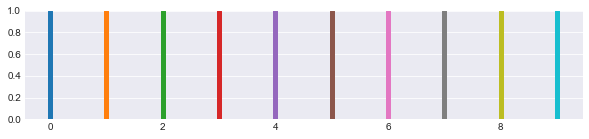

In [6]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
#print(colors)

#colors.pop(5)

fig,ax = plt.subplots(figsize=(10,2))
for i,color in enumerate(colors):
    ax.axvline(i,color=color,lw=5)

In [7]:
zref = 80.0
R2_min = 0.5

In [8]:
starttime = pd.datetime(2016,11,21,0,0,0)
endtime = pd.datetime(2016,11,22,12,0,0)
#resample_freq = '10S'
#t = pd.date_range(start=starttime,end=endtime,freq=resample_freq)

In [9]:
timezone_str = 'US/Pacific'
utc_tz = pytz.timezone('UTC')
local_tz = pytz.timezone(timezone_str)

In [10]:
# local weather

# station 726988 (air force datsav3 number), a.k.a. The Dalles Municipal Airport
# should be same data as:
# https://www.wunderground.com/history/airport/KDLS/2016/11/21/DailyHistory.html?req_city=&req_state=&req_statename=&reqdb.zip=&reqdb.magic=&reqdb.wmo=
isddata = '/Users/equon/WFIP2/weather/726988-24219-2016'

In [11]:
# Surface radiation measureents
srad_dpath = '/Users/equon/WFIP2/PS07/201611'
srad_prefix = 'met.z07.b0.2016112'
srad_ext = 'txt'

In [12]:
# SODAR (TI estimate)
ps01_dpath = '/Users/equon/WFIP2/PS01/sodar.z12.b0/201611'
ps01_prefix = ''
ps01_ext = 'txt'

In [13]:
# Wind Profiler 915Hz, RASS
rass_dpath = '/Users/equon/WFIP2/Wasco/radar.z04.b0/201611'
rass_prefix = 'radar.z04.b0.2016112'
rass_ext = '.temp.txt'

## PS-12
Surface Meteorological Station • ANL 80m, Sonic, Physics site-12 • Reviewed Data <br>
wfip2/met.z28.b0: south facing <br>
wfip2/met.z29.b0: west facing

In [14]:
# def load_ANL_met_data(fname,starttime=pd.datetime(1900,1,1),endtime=pd.datetime.now()):
#     df = pd.read_csv(fname,parse_dates=['collection_time'])
#     daterange = (df['collection_time'] >= starttime) & (df['collection_time'] <= endtime)
#     df = df.loc[daterange]
#     df['UTC'] = df['collection_time'].apply(lambda x: x.tz_localize(utc_tz))
#     df['local_time'] = df['UTC'].apply(lambda x: x.astimezone(local_tz) )
#     df['u'] = df['Y'] / 100.0 # positive toward east [m/s]
#     df['v'] = df['X'] / 100.0 # positive toward north [m/s]
#     df['w'] = df['Z'] / 100.0 # positive up [m/s]
#     df['temperature'] = df['T'] / 100.0 # sonic virtual temperature [deg C]
#     df['horizontal_wind_speed'] = np.sqrt(df['u']**2 + df['v']**2)
#     df['wind_speed'] = np.sqrt(df['u']**2 + df['v']**2 + df['w']**2)
#     df['wind_direction'] = 180.0/np.pi * (3*np.pi/2 - np.arctan2(df['v'],df['u']))
#     df['wind_direction'] = df['wind_direction'].apply(lambda wd: wd if wd < 360.0 else wd-360.0)
#     return df

In [15]:
def load_ANL_met_data(fname,starttime=pd.datetime(1900,1,1),endtime=pd.datetime.now(),datetimename='datetime'):
    df = pd.read_csv(fname,parse_dates=[datetimename])
    daterange = (df[datetimename] >= starttime) & (df[datetimename] <= endtime)
    df = df.loc[daterange]
    df['UTC'] = df[datetimename].apply(lambda x: x.tz_localize(utc_tz))
    df['local_time'] = df['UTC'].apply(lambda x: x.astimezone(local_tz) )
    df['horizontal_wind_speed'] = np.sqrt(df['u']**2 + df['v']**2)
    df['wind_speed'] = np.sqrt(df['u']**2 + df['v']**2 + df['w']**2)
    df['wind_direction'] = 180.0/np.pi * (3*np.pi/2 - np.arctan2(df['v'],df['u']))
    df['wind_direction'] = df['wind_direction'].apply(lambda wd: wd if wd < 360.0 else wd-360.0)
    df = df.rename({'Tv':'temperature'},axis=1)
    return df

In [16]:
# %time PS12_sonic80s = load_ANL_met_data('/Users/equon/WFIP2/met.z28.b0/met.z28.b0.csv',starttime,endtime)
# %time PS12_sonic80w = load_ANL_met_data('/Users/equon/WFIP2/met.z29.b0/met.z29.b0.csv',starttime,endtime)
%time PS12_sonic80s = load_ANL_met_data('/Users/equon/WFIP2/PS12/sonic80s_Nov2016.csv',starttime,endtime)
%time PS12_sonic80w = load_ANL_met_data('/Users/equon/WFIP2/PS12/sonic80w_Nov2016.csv',starttime,endtime)

CPU times: user 6.89 s, sys: 531 ms, total: 7.43 s
Wall time: 7.48 s
CPU times: user 6.88 s, sys: 510 ms, total: 7.39 s
Wall time: 7.42 s


In [17]:
# %time PS12_sonic50s = load_ANL_met_data('/Users/equon/WFIP2/met.z30.b0/met.z30.b0.csv',starttime,endtime)
# %time PS12_sonic50w = load_ANL_met_data('/Users/equon/WFIP2/met.z31.b0/met.z31.b0.csv',starttime,endtime)
%time PS12_sonic50s = load_ANL_met_data('/Users/equon/WFIP2/PS12/sonic50s_Nov2016.csv',starttime,endtime)
%time PS12_sonic50w = load_ANL_met_data('/Users/equon/WFIP2/PS12/sonic50w_Nov2016.csv',starttime,endtime)

CPU times: user 6.83 s, sys: 508 ms, total: 7.33 s
Wall time: 7.37 s
CPU times: user 6.89 s, sys: 517 ms, total: 7.41 s
Wall time: 7.45 s


In [18]:
PS12_sonic80s[['UTC','local_time','wind_speed','wind_direction','temperature','w']].to_csv('PS12_sonic80s_20161121.csv')
PS12_sonic80w[['UTC','local_time','wind_speed','wind_direction','temperature','w']].to_csv('PS12_sonic80w_20161121.csv')
PS12_sonic50s[['UTC','local_time','wind_speed','wind_direction','temperature','w']].to_csv('PS12_sonic50s_20161121.csv')
PS12_sonic50w[['UTC','local_time','wind_speed','wind_direction','temperature','w']].to_csv('PS12_sonic50w_20161121.csv')

In [19]:
# Calculate TI
def calc_TI(df,Navg=600):
    Umean = df['wind_speed'].rolling(Navg,center=True).mean()
    Ustdev = df['wind_speed'].rolling(Navg,center=True).std()
    df['TI_pct'] = 100 * Ustdev / Umean
    
    Umean = df['horizontal_wind_speed'].rolling(Navg,center=True).mean()
    Ustdev = df['horizontal_wind_speed'].rolling(Navg,center=True).std()
    df['TIxy_pct'] = 100 * Ustdev / Umean

    u = df['u']
    v = df['v']
    w = df['w']
    df['TKE'] = 0.5*(u.rolling(Navg,center=True).var() + v.rolling(Navg,center=True).var() + w.rolling(Navg,center=True).var())
    
calc_TI(PS12_sonic80s)
calc_TI(PS12_sonic80w)
calc_TI(PS12_sonic50s)
calc_TI(PS12_sonic50w)

## SCADA

In [20]:
data_path = 'PGE/20161121'
sys.path.append('/Users/equon/WFIP2/PGE/OA_analysis/biglow/oa_project')
import project_bl
import operational_analysis

toollist = ["filtering_analysis","air_density_analysis","imputing_analysis","timeseries_analysis","power_curve_analysis","windflow_analysis"]
plant = project_bl.ProjectBL(data_path,'biglow',engine="pandas", toolkit=toollist)

%time plant.load_data(asset=True,tower=True,scada=True,merra=False)

/Users/equon/miniconda2/envs/python2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
/Users/equon/operational-analysis/operational_analysis/input_data_QC.py:13: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/Users/equon/miniconda2/envs/python2/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/Users/equon/miniconda2/envs/python2/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/Users/equon/miniconda2/envs/python2/lib/

CPU times: user 373 ms, sys: 59.6 ms, total: 432 ms
Wall time: 454 ms


In [21]:
%time plant.scada.df['UTC'] = plant.scada.df['time'].apply(lambda x: x.tz_localize(utc_tz) )

CPU times: user 2.15 s, sys: 92.9 ms, total: 2.25 s
Wall time: 2.22 s


In [22]:
%time plant.scada.df['local_time'] = plant.scada.df['UTC'].apply(lambda x: x.astimezone(local_tz) )

CPU times: user 2.71 s, sys: 76.8 ms, total: 2.79 s
Wall time: 2.78 s


In [23]:
plant.scada.df.head()

,Unnamed: 0,Unnamed: 0.1,time,power_kw,winddirection_deg,windspeed_ms,id,pitch_deg,UTC,local_time
0,146343,146343,2016-11-21 00:01:00,122.175514,58.355064,4.412018,tower001,NaN,2016-11-21 00:01:00+00:00,2016-11-20 16:01:00-08:00
1,146344,146344,2016-11-21 00:03:00,131.074808,60.000000,4.812035,tower001,NaN,2016-11-21 00:03:00+00:00,2016-11-20 16:03:00-08:00
2,146345,146345,2016-11-21 00:05:00,176.419702,60.000000,5.161069,tower001,NaN,2016-11-21 00:05:00+00:00,2016-11-20 16:05:00-08:00
3,146346,146346,2016-11-21 00:07:00,201.558328,48.745502,5.376078,tower001,NaN,2016-11-21 00:07:00+00:00,2016-11-20 16:07:00-08:00
4,146347,146347,2016-11-21 00:09:00,182.539874,40.677161,5.423307,tower001,NaN,2016-11-21 00:09:00+00:00,2016-11-20 16:09:00-08:00


### <font color='red'>more sophisticated filtering here...</font>

In [24]:
### SCADA: measurement based flags
p = plant.scada_filter_parameters 
p['bin_ws_power_width'] = 50.
p['bin_ws_std'] = 2.

In [25]:
plant.scada_filter_parameters

{'bin_pitch_std': 2.0,
 'bin_pitch_ws_width': 0.5,
 'bin_power_std': 2.0,
 'bin_power_ws_width': 0.5,
 'bin_ws_power_width': 50.0,
 'bin_ws_std': 2.0,
 'pitch_lower': -20.0,
 'pitch_upper': 20.0,
 'power_irresponsive_sensor_run_length': 2,
 'power_lower': 10,
 'power_upper': inf,
 'winddirection_irresponsive_sensor_run_length': 2,
 'winddirection_lower': 0.0,
 'winddirection_upper': 360.0,
 'window_pitch_lower': -3.0,
 'window_pitch_upper': 3.0,
 'window_pitch_ws_lower': 0.0,
 'window_pitch_ws_upper': 10.0,
 'window_power_lower': 1200.0,
 'window_power_upper': inf,
 'window_power_ws_lower': 14.5,
 'window_power_ws_upper': inf,
 'windspeed_irresponsive_sensor_run_length': 2,
 'windspeed_lower': 0.0,
 'windspeed_upper': 30.0}

In [26]:
# Perform low power filter beyond cut in wind speed filter
y_col ='power_kw' 
x_col = 'windspeed_ms'
y_thresh = [10, 100, 400, 750]
x_min = [4, 6, 8, 10] # Cut in wind speed

low_power_flag = plant.filtering_analysis.low_value_cut_off(
        plant.scada.df[[x_col, y_col, 'time', 'id']],
        x_col, y_col,
        x_min, y_thresh)
plant.scada.df = plant.scada.df.merge(low_power_flag, on=['time', 'id'])

/Users/equon/operational-analysis/operational_analysis/filtering_analysis.py:359: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  flag[flag_col] = False
/Users/equon/miniconda2/envs/python2/lib/python2.7/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


# time-zone specific calculations from here forward!

In [27]:
#tindex = 'local_time'
tindex = 'UTC'

In [28]:
# plotstart = starttime
# plotend = endtime
plotstart = pd.to_datetime('2016-11-21 17:00:00')
plotend = pd.to_datetime('2016-11-22 05:00:00')

In [29]:
def clean_up_xaxis(ax):
    ax[-1].set_xlim((plotstart,plotend))
    plottimes = pd.date_range(plotstart,plotend,freq='1H')
    plotlocal = plottimes.tz_localize(pytz.utc).tz_convert(timezone_str)
    ax[-1].set_xticks(plottimes)
    xlabels = [t.strftime('%H:%M\n')+tloc.strftime('%H:%M') for t,tloc in zip(plottimes,plotlocal)]
    ax[-1].set_xticklabels(xlabels)
    ax[-1].set_xlabel('UTC\nlocal time')
    plt.minorticks_off()

In [30]:
focusstart = pd.to_datetime('2016-11-21 22:15')
focusend = pd.to_datetime('2016-11-21 23:15')
def highlight_period(ax,start=focusstart,end=focusend):
    for a in ax:
        a.axvspan(start, end, facecolor='0.8', alpha=0.5)

## Calculate 1-min means

In [31]:
#filtered = plant.scada.df['running']
filtered = ~plant.scada.df['low_power_kw_cutoff']

scada_1min = plant.scada.df.loc[filtered].resample('1min',on=tindex).mean()
scada_1min = scada_1min.interpolate()

<font color='blue'>RE-RUN THIS AFTER RE-LOADING AND PROCESSING THE ORIGINAL DATA</font>

In [32]:
sonic80s_1Hz = PS12_sonic80s.set_index(tindex).resample('1s').mean()
sonic80w_1Hz = PS12_sonic80w.set_index(tindex).resample('1s').mean()

In [33]:
sonic50s_1Hz = PS12_sonic50s.set_index(tindex).resample('1s').mean()
sonic50w_1Hz = PS12_sonic50w.set_index(tindex).resample('1s').mean()

In [34]:
sonic80s_1min = PS12_sonic80s.set_index(tindex).resample('1min').mean()
sonic80w_1min = PS12_sonic80w.set_index(tindex).resample('1min').mean()

In [35]:
sonic50s_1min = PS12_sonic50s.set_index(tindex).resample('1min').mean()
sonic50w_1min = PS12_sonic50w.set_index(tindex).resample('1min').mean()

In [36]:
sw_avg_vars = ['wind_speed','wind_direction','temperature','w','TI_pct','TIxy_pct','TKE']

PS12_80m_1min = 0.5*(sonic80s_1min[sw_avg_vars] + sonic80w_1min[sw_avg_vars])
PS12_50m_1min = 0.5*(sonic50s_1min[sw_avg_vars] + sonic50w_1min[sw_avg_vars])

## Other calculations (shear, Ri, ...)

In [37]:
from abl.meteorology import fit_power_law_alpha

In [38]:
# estimate shear coefficients
PS12_shear_1min = pd.Series(name='shear', index=PS12_80m_1min.index)
windspeeds = pd.concat([PS12_50m_1min['wind_speed'], PS12_80m_1min['wind_speed']],axis=1)
zfit = np.array([50.0, 80.0])
for tstamp,Ufit in windspeeds.iterrows():
    alpha, R2 = fit_power_law_alpha(zfit, Ufit, zref=zref, Uref=Ufit[1])
    if R2 < R2_min:
        alpha = np.nan
    PS12_shear_1min[tstamp] = alpha
    print(tstamp,alpha,R2)

(Timestamp('2016-11-21 00:00:00+0000', tz='UTC', freq='T'), 0.057273765934930117, 1.0)
(Timestamp('2016-11-21 00:01:00+0000', tz='UTC', freq='T'), 0.27115918316574528, 1.0)
(Timestamp('2016-11-21 00:02:00+0000', tz='UTC', freq='T'), nan, -1.0000004618029852)
(Timestamp('2016-11-21 00:03:00+0000', tz='UTC', freq='T'), 0.15029877462216482, 1.0)
(Timestamp('2016-11-21 00:04:00+0000', tz='UTC', freq='T'), nan, -1.0000097474163256)
(Timestamp('2016-11-21 00:05:00+0000', tz='UTC', freq='T'), 0.16399425686912511, 0.99999999999774658)
(Timestamp('2016-11-21 00:06:00+0000', tz='UTC', freq='T'), 0.37986104187176473, 1.0)
(Timestamp('2016-11-21 00:07:00+0000', tz='UTC', freq='T'), 0.24054785005400242, 1.0)
(Timestamp('2016-11-21 00:08:00+0000', tz='UTC', freq='T'), 0.63115030347334522, 1.0)
(Timestamp('2016-11-21 00:09:00+0000', tz='UTC', freq='T'), 0.38359449886629859, 1.0)
(Timestamp('2016-11-21 00:10:00+0000', tz='UTC', freq='T'), nan, -1.0000000497702488)
(Timestamp('2016-11-21 00:11:00+0000'

(Timestamp('2016-11-21 01:50:00+0000', tz='UTC', freq='T'), 0.042270733340538588, 0.99999999999987599)
(Timestamp('2016-11-21 01:51:00+0000', tz='UTC', freq='T'), 0.043272888900251126, 0.99999999999994515)
(Timestamp('2016-11-21 01:52:00+0000', tz='UTC', freq='T'), nan, -1.0000571335522626)
(Timestamp('2016-11-21 01:53:00+0000', tz='UTC', freq='T'), 0.037274508187191344, 0.9999999999932716)
(Timestamp('2016-11-21 01:54:00+0000', tz='UTC', freq='T'), 0.091930068416732902, 1.0)
(Timestamp('2016-11-21 01:55:00+0000', tz='UTC', freq='T'), 0.033713508637239806, 0.99999999989233324)
(Timestamp('2016-11-21 01:56:00+0000', tz='UTC', freq='T'), 0.32044779183752536, 1.0)
(Timestamp('2016-11-21 01:57:00+0000', tz='UTC', freq='T'), 0.35567901484679953, 1.0)
(Timestamp('2016-11-21 01:58:00+0000', tz='UTC', freq='T'), 0.41230915860041245, 1.0)
(Timestamp('2016-11-21 01:59:00+0000', tz='UTC', freq='T'), 0.31307620751128656, 1.0)
(Timestamp('2016-11-21 02:00:00+0000', tz='UTC', freq='T'), 0.4680131751

(Timestamp('2016-11-21 03:42:00+0000', tz='UTC', freq='T'), 0.40363880859674423, 1.0)
(Timestamp('2016-11-21 03:43:00+0000', tz='UTC', freq='T'), 0.34735201631045831, 1.0)
(Timestamp('2016-11-21 03:44:00+0000', tz='UTC', freq='T'), 0.21122786134303578, 1.0)
(Timestamp('2016-11-21 03:45:00+0000', tz='UTC', freq='T'), 0.30018335549475805, 1.0)
(Timestamp('2016-11-21 03:46:00+0000', tz='UTC', freq='T'), 0.36936069929527976, 1.0)
(Timestamp('2016-11-21 03:47:00+0000', tz='UTC', freq='T'), 0.53597619810103647, 1.0)
(Timestamp('2016-11-21 03:48:00+0000', tz='UTC', freq='T'), 0.272162253451326, 1.0)
(Timestamp('2016-11-21 03:49:00+0000', tz='UTC', freq='T'), 0.25605651480476993, 1.0)
(Timestamp('2016-11-21 03:50:00+0000', tz='UTC', freq='T'), 0.13915314482040037, 1.0)
(Timestamp('2016-11-21 03:51:00+0000', tz='UTC', freq='T'), 0.36151640052208767, 1.0)
(Timestamp('2016-11-21 03:52:00+0000', tz='UTC', freq='T'), 0.51936886135045701, 1.0)
(Timestamp('2016-11-21 03:53:00+0000', tz='UTC', freq='T

(Timestamp('2016-11-21 05:50:00+0000', tz='UTC', freq='T'), nan, -30.597980832511443)
(Timestamp('2016-11-21 05:51:00+0000', tz='UTC', freq='T'), 0.19036019089625511, 1.0)
(Timestamp('2016-11-21 05:52:00+0000', tz='UTC', freq='T'), 0.038577804566221945, 0.99999999999759781)
(Timestamp('2016-11-21 05:53:00+0000', tz='UTC', freq='T'), 0.30734922524328118, 1.0)
(Timestamp('2016-11-21 05:54:00+0000', tz='UTC', freq='T'), 0.40348410928957551, 1.0)
(Timestamp('2016-11-21 05:55:00+0000', tz='UTC', freq='T'), 0.14312734062992619, 1.0)
(Timestamp('2016-11-21 05:56:00+0000', tz='UTC', freq='T'), nan, -1.0000002068032892)
(Timestamp('2016-11-21 05:57:00+0000', tz='UTC', freq='T'), nan, -1.0000000001653504)
(Timestamp('2016-11-21 05:58:00+0000', tz='UTC', freq='T'), nan, -1.0000002429018888)
(Timestamp('2016-11-21 05:59:00+0000', tz='UTC', freq='T'), nan, -1.0000000892217176)
(Timestamp('2016-11-21 06:00:00+0000', tz='UTC', freq='T'), 0.29201216198912833, 1.0)
(Timestamp('2016-11-21 06:01:00+0000'

(Timestamp('2016-11-21 07:53:00+0000', tz='UTC', freq='T'), 0.086670862759808648, 0.99999999999999967)
(Timestamp('2016-11-21 07:54:00+0000', tz='UTC', freq='T'), 0.22443923007383476, 1.0)
(Timestamp('2016-11-21 07:55:00+0000', tz='UTC', freq='T'), 0.098087175772405125, 1.0)
(Timestamp('2016-11-21 07:56:00+0000', tz='UTC', freq='T'), 0.028402914892610768, 0.99999999395756933)
(Timestamp('2016-11-21 07:57:00+0000', tz='UTC', freq='T'), nan, -1.0000171945745655)
(Timestamp('2016-11-21 07:58:00+0000', tz='UTC', freq='T'), 0.16345103259955679, 0.99999999999713574)
(Timestamp('2016-11-21 07:59:00+0000', tz='UTC', freq='T'), 0.76003389572269819, 1.0)
(Timestamp('2016-11-21 08:00:00+0000', tz='UTC', freq='T'), 0.74355670706428856, 1.0)
(Timestamp('2016-11-21 08:01:00+0000', tz='UTC', freq='T'), 0.71544472679315629, 1.0)
(Timestamp('2016-11-21 08:02:00+0000', tz='UTC', freq='T'), 0.87986365012742274, 1.0)
(Timestamp('2016-11-21 08:03:00+0000', tz='UTC', freq='T'), 0.99295444654995135, 1.0)
(Ti

(Timestamp('2016-11-21 09:46:00+0000', tz='UTC', freq='T'), nan, -1.0000008466257038)
(Timestamp('2016-11-21 09:47:00+0000', tz='UTC', freq='T'), nan, -1.0000000341204491)
(Timestamp('2016-11-21 09:48:00+0000', tz='UTC', freq='T'), nan, -1.0000000066914252)
(Timestamp('2016-11-21 09:49:00+0000', tz='UTC', freq='T'), nan, -1.000000035574101)
(Timestamp('2016-11-21 09:50:00+0000', tz='UTC', freq='T'), nan, -1.0000000296012441)
(Timestamp('2016-11-21 09:51:00+0000', tz='UTC', freq='T'), nan, -1.000000028152864)
(Timestamp('2016-11-21 09:52:00+0000', tz='UTC', freq='T'), nan, -1.0000000006414771)
(Timestamp('2016-11-21 09:53:00+0000', tz='UTC', freq='T'), nan, -1.0000000002443885)
(Timestamp('2016-11-21 09:54:00+0000', tz='UTC', freq='T'), nan, -1.0000000001402709)
(Timestamp('2016-11-21 09:55:00+0000', tz='UTC', freq='T'), nan, -1.0000000000692264)
(Timestamp('2016-11-21 09:56:00+0000', tz='UTC', freq='T'), nan, -1.0000000000128555)
(Timestamp('2016-11-21 09:57:00+0000', tz='UTC', freq='T

(Timestamp('2016-11-21 11:32:00+0000', tz='UTC', freq='T'), 0.68042584270966533, 1.0)
(Timestamp('2016-11-21 11:33:00+0000', tz='UTC', freq='T'), 0.7179782091408784, 1.0)
(Timestamp('2016-11-21 11:34:00+0000', tz='UTC', freq='T'), 0.50893495804807665, 1.0)
(Timestamp('2016-11-21 11:35:00+0000', tz='UTC', freq='T'), 0.34200836764650999, 1.0)
(Timestamp('2016-11-21 11:36:00+0000', tz='UTC', freq='T'), 0.43242329644776162, 1.0)
(Timestamp('2016-11-21 11:37:00+0000', tz='UTC', freq='T'), 0.69289402540747091, 1.0)
(Timestamp('2016-11-21 11:38:00+0000', tz='UTC', freq='T'), 0.9185501992802475, 1.0)
(Timestamp('2016-11-21 11:39:00+0000', tz='UTC', freq='T'), 0.38055918859456223, 1.0)
(Timestamp('2016-11-21 11:40:00+0000', tz='UTC', freq='T'), 0.32484633336641583, 1.0)
(Timestamp('2016-11-21 11:41:00+0000', tz='UTC', freq='T'), 0.27977106279318953, 1.0)
(Timestamp('2016-11-21 11:42:00+0000', tz='UTC', freq='T'), 0.57117850223300981, 1.0)
(Timestamp('2016-11-21 11:43:00+0000', tz='UTC', freq='T

(Timestamp('2016-11-21 13:31:00+0000', tz='UTC', freq='T'), 0.5901143171978932, 1.0)
(Timestamp('2016-11-21 13:32:00+0000', tz='UTC', freq='T'), 0.61792953685290053, 1.0)
(Timestamp('2016-11-21 13:33:00+0000', tz='UTC', freq='T'), 0.63049105355341528, 1.0)
(Timestamp('2016-11-21 13:34:00+0000', tz='UTC', freq='T'), 0.66551371716837004, 1.0)
(Timestamp('2016-11-21 13:35:00+0000', tz='UTC', freq='T'), 0.61670763958145558, 1.0)
(Timestamp('2016-11-21 13:36:00+0000', tz='UTC', freq='T'), 0.55068440748543535, 1.0)
(Timestamp('2016-11-21 13:37:00+0000', tz='UTC', freq='T'), 0.6280297131051662, 1.0)
(Timestamp('2016-11-21 13:38:00+0000', tz='UTC', freq='T'), 0.68190389623308278, 1.0)
(Timestamp('2016-11-21 13:39:00+0000', tz='UTC', freq='T'), 0.68654465197471826, 1.0)
(Timestamp('2016-11-21 13:40:00+0000', tz='UTC', freq='T'), 0.76932559007752244, 1.0)
(Timestamp('2016-11-21 13:41:00+0000', tz='UTC', freq='T'), 0.72054248894367867, 1.0)
(Timestamp('2016-11-21 13:42:00+0000', tz='UTC', freq='T

(Timestamp('2016-11-21 15:33:00+0000', tz='UTC', freq='T'), 0.91432315807987041, 1.0)
(Timestamp('2016-11-21 15:34:00+0000', tz='UTC', freq='T'), 0.85986201125861861, 1.0)
(Timestamp('2016-11-21 15:35:00+0000', tz='UTC', freq='T'), 0.95905566598111247, 1.0)
(Timestamp('2016-11-21 15:36:00+0000', tz='UTC', freq='T'), 0.80691592257044475, 1.0)
(Timestamp('2016-11-21 15:37:00+0000', tz='UTC', freq='T'), 0.71878192427050824, 1.0)
(Timestamp('2016-11-21 15:38:00+0000', tz='UTC', freq='T'), 0.88246920279081742, 1.0)
(Timestamp('2016-11-21 15:39:00+0000', tz='UTC', freq='T'), 1.170030856017074, 1.0)
(Timestamp('2016-11-21 15:40:00+0000', tz='UTC', freq='T'), 1.2207250396949865, 1.0)
(Timestamp('2016-11-21 15:41:00+0000', tz='UTC', freq='T'), 0.83490105007078697, 1.0)
(Timestamp('2016-11-21 15:42:00+0000', tz='UTC', freq='T'), 0.48918108663673932, 1.0)
(Timestamp('2016-11-21 15:43:00+0000', tz='UTC', freq='T'), 0.85177163634826614, 1.0)
(Timestamp('2016-11-21 15:44:00+0000', tz='UTC', freq='T'

(Timestamp('2016-11-21 17:29:00+0000', tz='UTC', freq='T'), 0.44427822477722767, 1.0)
(Timestamp('2016-11-21 17:30:00+0000', tz='UTC', freq='T'), 0.80537053997176744, 1.0)
(Timestamp('2016-11-21 17:31:00+0000', tz='UTC', freq='T'), 0.79145962735268405, 1.0)
(Timestamp('2016-11-21 17:32:00+0000', tz='UTC', freq='T'), 0.72351608131060674, 1.0)
(Timestamp('2016-11-21 17:33:00+0000', tz='UTC', freq='T'), 0.69049700656282686, 1.0)
(Timestamp('2016-11-21 17:34:00+0000', tz='UTC', freq='T'), 0.36158098109376258, 1.0)
(Timestamp('2016-11-21 17:35:00+0000', tz='UTC', freq='T'), 0.2327819702907378, 1.0)
(Timestamp('2016-11-21 17:36:00+0000', tz='UTC', freq='T'), 0.28860213351792635, 1.0)
(Timestamp('2016-11-21 17:37:00+0000', tz='UTC', freq='T'), 0.56214394396532164, 1.0)
(Timestamp('2016-11-21 17:38:00+0000', tz='UTC', freq='T'), 0.39278452800311592, 1.0)
(Timestamp('2016-11-21 17:39:00+0000', tz='UTC', freq='T'), 0.24477931570866618, 1.0)
(Timestamp('2016-11-21 17:40:00+0000', tz='UTC', freq='

(Timestamp('2016-11-21 19:32:00+0000', tz='UTC', freq='T'), 0.14802761477471071, 1.0)
(Timestamp('2016-11-21 19:33:00+0000', tz='UTC', freq='T'), 0.07187010458359544, 0.99999999999918709)
(Timestamp('2016-11-21 19:34:00+0000', tz='UTC', freq='T'), 0.12701186567223954, 0.99999999999998157)
(Timestamp('2016-11-21 19:35:00+0000', tz='UTC', freq='T'), 0.08657968348711291, 0.99999999999999967)
(Timestamp('2016-11-21 19:36:00+0000', tz='UTC', freq='T'), 0.091905544531091177, 1.0)
(Timestamp('2016-11-21 19:37:00+0000', tz='UTC', freq='T'), nan, -1.0000478302781097)
(Timestamp('2016-11-21 19:38:00+0000', tz='UTC', freq='T'), nan, -1.0000186042237424)
(Timestamp('2016-11-21 19:39:00+0000', tz='UTC', freq='T'), 0.16454171295055983, 0.99999999999823697)
(Timestamp('2016-11-21 19:40:00+0000', tz='UTC', freq='T'), 0.11149168086658134, 0.99999999999111322)
(Timestamp('2016-11-21 19:41:00+0000', tz='UTC', freq='T'), nan, -1.0000356305685649)
(Timestamp('2016-11-21 19:42:00+0000', tz='UTC', freq='T'),

(Timestamp('2016-11-21 21:12:00+0000', tz='UTC', freq='T'), nan, -1.5548249905702929)
(Timestamp('2016-11-21 21:13:00+0000', tz='UTC', freq='T'), nan, -1.0000301342053888)
(Timestamp('2016-11-21 21:14:00+0000', tz='UTC', freq='T'), nan, -1.0004940644031315)
(Timestamp('2016-11-21 21:15:00+0000', tz='UTC', freq='T'), nan, -1.0000001243832402)
(Timestamp('2016-11-21 21:16:00+0000', tz='UTC', freq='T'), 0.12847472833582887, 0.99999999999999034)
(Timestamp('2016-11-21 21:17:00+0000', tz='UTC', freq='T'), 0.0034605931557581317, 0.99999996539128522)
(Timestamp('2016-11-21 21:18:00+0000', tz='UTC', freq='T'), 0.012193117215557653, 0.99999999999997946)
(Timestamp('2016-11-21 21:19:00+0000', tz='UTC', freq='T'), 0.08525764049524491, 0.99999999999999933)
(Timestamp('2016-11-21 21:20:00+0000', tz='UTC', freq='T'), 0.11823471621158721, 0.99999999999929845)
(Timestamp('2016-11-21 21:21:00+0000', tz='UTC', freq='T'), 0.021464778465710765, 0.9999999999995276)
(Timestamp('2016-11-21 21:22:00+0000', tz

(Timestamp('2016-11-21 22:55:00+0000', tz='UTC', freq='T'), nan, -1.0000020268707135)
(Timestamp('2016-11-21 22:56:00+0000', tz='UTC', freq='T'), 0.023414192843071349, 0.99999999999997158)
(Timestamp('2016-11-21 22:57:00+0000', tz='UTC', freq='T'), 0.078462837197774568, 0.99999999999997247)
(Timestamp('2016-11-21 22:58:00+0000', tz='UTC', freq='T'), 0.042795138378244162, 0.99999999999991906)
(Timestamp('2016-11-21 22:59:00+0000', tz='UTC', freq='T'), 0.050970485438295042, 0.99999999999999989)
(Timestamp('2016-11-21 23:00:00+0000', tz='UTC', freq='T'), 0.14078332563635362, 1.0)
(Timestamp('2016-11-21 23:01:00+0000', tz='UTC', freq='T'), 0.0090455803997269452, 0.99999999989815946)
(Timestamp('2016-11-21 23:02:00+0000', tz='UTC', freq='T'), 0.037316528065640842, 0.99999999999349054)
(Timestamp('2016-11-21 23:03:00+0000', tz='UTC', freq='T'), 0.15510025338180339, 1.0)
(Timestamp('2016-11-21 23:04:00+0000', tz='UTC', freq='T'), 0.092455962627142563, 1.0)
(Timestamp('2016-11-21 23:05:00+0000

(Timestamp('2016-11-22 00:53:00+0000', tz='UTC', freq='T'), 0.1408987978333236, 1.0)
(Timestamp('2016-11-22 00:54:00+0000', tz='UTC', freq='T'), 0.20099359988470245, 1.0)
(Timestamp('2016-11-22 00:55:00+0000', tz='UTC', freq='T'), 0.25989702274480669, 1.0)
(Timestamp('2016-11-22 00:56:00+0000', tz='UTC', freq='T'), 0.32717601625887494, 1.0)
(Timestamp('2016-11-22 00:57:00+0000', tz='UTC', freq='T'), 0.1089367608186228, 0.99999999997788036)
(Timestamp('2016-11-22 00:58:00+0000', tz='UTC', freq='T'), 0.14517248159725574, 1.0)
(Timestamp('2016-11-22 00:59:00+0000', tz='UTC', freq='T'), 0.18988702367531068, 1.0)
(Timestamp('2016-11-22 01:00:00+0000', tz='UTC', freq='T'), 0.13882360341891983, 0.99999999999999989)
(Timestamp('2016-11-22 01:01:00+0000', tz='UTC', freq='T'), 0.13909300132406405, 0.99999999999999989)
(Timestamp('2016-11-22 01:02:00+0000', tz='UTC', freq='T'), 0.16886720433836078, 0.99999999999978051)
(Timestamp('2016-11-22 01:03:00+0000', tz='UTC', freq='T'), 0.1602279733983681

(Timestamp('2016-11-22 03:09:00+0000', tz='UTC', freq='T'), 0.10603874553428015, 1.0)
(Timestamp('2016-11-22 03:10:00+0000', tz='UTC', freq='T'), 0.13461251045972558, 0.99999999999999944)
(Timestamp('2016-11-22 03:11:00+0000', tz='UTC', freq='T'), 0.23886173778562014, 1.0)
(Timestamp('2016-11-22 03:12:00+0000', tz='UTC', freq='T'), 0.24605590589604423, 1.0)
(Timestamp('2016-11-22 03:13:00+0000', tz='UTC', freq='T'), 0.38194583010485639, 1.0)
(Timestamp('2016-11-22 03:14:00+0000', tz='UTC', freq='T'), 0.43765868792559465, 1.0)
(Timestamp('2016-11-22 03:15:00+0000', tz='UTC', freq='T'), 0.44188239226026499, 1.0)
(Timestamp('2016-11-22 03:16:00+0000', tz='UTC', freq='T'), 0.43130729969124554, 1.0)
(Timestamp('2016-11-22 03:17:00+0000', tz='UTC', freq='T'), 0.53380666880811334, 1.0)
(Timestamp('2016-11-22 03:18:00+0000', tz='UTC', freq='T'), 0.31314014457086187, 1.0)
(Timestamp('2016-11-22 03:19:00+0000', tz='UTC', freq='T'), 0.25308816402122492, 1.0)
(Timestamp('2016-11-22 03:20:00+0000',

(Timestamp('2016-11-22 04:59:00+0000', tz='UTC', freq='T'), 0.50309119260726076, 1.0)
(Timestamp('2016-11-22 05:00:00+0000', tz='UTC', freq='T'), 0.46253476648978681, 1.0)
(Timestamp('2016-11-22 05:01:00+0000', tz='UTC', freq='T'), 0.42476993864868401, 1.0)
(Timestamp('2016-11-22 05:02:00+0000', tz='UTC', freq='T'), 0.52970757585442141, 1.0)
(Timestamp('2016-11-22 05:03:00+0000', tz='UTC', freq='T'), 0.38832641223267378, 1.0)
(Timestamp('2016-11-22 05:04:00+0000', tz='UTC', freq='T'), 0.11148881397443786, 0.999999999991104)
(Timestamp('2016-11-22 05:05:00+0000', tz='UTC', freq='T'), 0.098530494096543422, 1.0)
(Timestamp('2016-11-22 05:06:00+0000', tz='UTC', freq='T'), 0.089400124152495999, 0.99999999999999989)
(Timestamp('2016-11-22 05:07:00+0000', tz='UTC', freq='T'), 0.088970784151635757, 0.99999999999999989)
(Timestamp('2016-11-22 05:08:00+0000', tz='UTC', freq='T'), 0.093320621117910493, 1.0)
(Timestamp('2016-11-22 05:09:00+0000', tz='UTC', freq='T'), 0.21680842102647288, 1.0)
(Tim

(Timestamp('2016-11-22 06:39:00+0000', tz='UTC', freq='T'), nan, -1.0000000055511284)
(Timestamp('2016-11-22 06:40:00+0000', tz='UTC', freq='T'), nan, -1.000017139700383)
(Timestamp('2016-11-22 06:41:00+0000', tz='UTC', freq='T'), nan, -1.0000000650263603)
(Timestamp('2016-11-22 06:42:00+0000', tz='UTC', freq='T'), 0.086155100241492769, 0.99999999999999956)
(Timestamp('2016-11-22 06:43:00+0000', tz='UTC', freq='T'), 0.035305373256630516, 0.99999999996859545)
(Timestamp('2016-11-22 06:44:00+0000', tz='UTC', freq='T'), nan, -1.0000016631826552)
(Timestamp('2016-11-22 06:45:00+0000', tz='UTC', freq='T'), nan, -1.0000162433871957)
(Timestamp('2016-11-22 06:46:00+0000', tz='UTC', freq='T'), 0.0099169691978696108, 0.99999999999021261)
(Timestamp('2016-11-22 06:47:00+0000', tz='UTC', freq='T'), 0.0027796498045377315, 0.99999879257947732)
(Timestamp('2016-11-22 06:48:00+0000', tz='UTC', freq='T'), 0.2662690808785742, 1.0)
(Timestamp('2016-11-22 06:49:00+0000', tz='UTC', freq='T'), 0.3119520137

(Timestamp('2016-11-22 08:48:00+0000', tz='UTC', freq='T'), 0.12366369811335781, 0.9999999999999224)
(Timestamp('2016-11-22 08:49:00+0000', tz='UTC', freq='T'), 0.1883356891441868, 1.0)
(Timestamp('2016-11-22 08:50:00+0000', tz='UTC', freq='T'), 0.099079968824511935, 1.0)
(Timestamp('2016-11-22 08:51:00+0000', tz='UTC', freq='T'), 0.19353378249240677, 0.99999999999782074)
(Timestamp('2016-11-22 08:52:00+0000', tz='UTC', freq='T'), 0.17577608480418816, 0.999999999999996)
(Timestamp('2016-11-22 08:53:00+0000', tz='UTC', freq='T'), 0.1860883524728055, 1.0)
(Timestamp('2016-11-22 08:54:00+0000', tz='UTC', freq='T'), 0.22021263423696613, 1.0)
(Timestamp('2016-11-22 08:55:00+0000', tz='UTC', freq='T'), 0.60548312741540311, 1.0)
(Timestamp('2016-11-22 08:56:00+0000', tz='UTC', freq='T'), 0.54197169612468543, 1.0)
(Timestamp('2016-11-22 08:57:00+0000', tz='UTC', freq='T'), 0.59991805107770091, 1.0)
(Timestamp('2016-11-22 08:58:00+0000', tz='UTC', freq='T'), 0.2922360641417836, 1.0)
(Timestamp(

(Timestamp('2016-11-22 10:38:00+0000', tz='UTC', freq='T'), 0.015639622301518909, 0.99999999824059338)
(Timestamp('2016-11-22 10:39:00+0000', tz='UTC', freq='T'), 0.089127059990446802, 0.99999999999999989)
(Timestamp('2016-11-22 10:40:00+0000', tz='UTC', freq='T'), nan, -1.0000000002289959)
(Timestamp('2016-11-22 10:41:00+0000', tz='UTC', freq='T'), nan, -1.0000000236718702)
(Timestamp('2016-11-22 10:42:00+0000', tz='UTC', freq='T'), nan, -1.0000207826088312)
(Timestamp('2016-11-22 10:43:00+0000', tz='UTC', freq='T'), 0.076723067694860841, 0.9999999999999315)
(Timestamp('2016-11-22 10:44:00+0000', tz='UTC', freq='T'), 0.09088317692053606, 1.0)
(Timestamp('2016-11-22 10:45:00+0000', tz='UTC', freq='T'), 0.29468503909531057, 1.0)
(Timestamp('2016-11-22 10:46:00+0000', tz='UTC', freq='T'), 0.49111612462287135, 1.0)
(Timestamp('2016-11-22 10:47:00+0000', tz='UTC', freq='T'), 0.5563864830391827, 1.0)
(Timestamp('2016-11-22 10:48:00+0000', tz='UTC', freq='T'), 0.61745989195857087, 1.0)
(Time

In [39]:
# calculate bulk Richardson number (approximation to the gradient Richardson number)
def bulk_rich(df1,df2,z=[50.,80.],window=600):
    WS1 = df1['wind_speed'].rolling(window,center=True).mean()
    WS2 = df2['wind_speed'].rolling(window,center=True).mean()
    Tv = 0.5*(df1['temperature']+df2['temperature']).rolling(window,center=True).mean() + 273.15
    theta1 = (df1['temperature'] + 0.0098*z[0]).rolling(window,center=True).mean()
    theta2 = (df2['temperature'] + 0.0098*z[1]).rolling(window,center=True).mean()
    print(Tv.mean(),(theta2-theta1).mean())
    dU = WS2 - WS1
    Ri = 9.81/Tv*(theta2-theta1)*(z[1]-z[0])/(dU)**2
    Ri = Ri.loc[dU > 0]
    return Ri.resample('10min').mean()

In [40]:
PS12_richno_10min = bulk_rich(PS12_sonic50w.set_index('UTC'), PS12_sonic80w.set_index('UTC'))

(552.96204092895198, -1.0465522389834918)


In [41]:
PS12_richno_10min = PS12_richno_10min.loc[~PS12_richno_10min.isna()]

## Set up corresponding met-measured wind direction

In [42]:
# 1-min averaged values from 80-m sonics on PS12
wdir1 = sonic80s_1min['wind_direction']
wdir2 = sonic80w_1min['wind_direction']

In [43]:
# make sure we have the same range of times as the scada data
scada_start = scada_1min.index[0]
scada_end = scada_1min.index[-1]
print(scada_start, scada_end)

trange1 = (wdir1.index >= scada_start) & (wdir1.index <= scada_end)
trange2 = (wdir2.index >= scada_start) & (wdir2.index <= scada_end)

wdir1 = wdir1.loc[trange1]
wdir2 = wdir2.loc[trange2]

(Timestamp('2016-11-21 00:01:00+0000', tz='UTC', freq='T'), Timestamp('2016-11-22 11:59:00+0000', tz='UTC', freq='T'))


In [44]:
# PS12_sonic80s_1min = (2*PS12_sonic80s_1min).round() / 2
# PS12_sonic80w_1min = (2*PS12_sonic80w_1min).round() / 2
PS12_wdir_1min = (wdir1 + wdir2).round() / 2

In [45]:
PS12_wdir_1min.head()

UTC
2016-11-21 00:01:00+00:00    253.5
2016-11-21 00:02:00+00:00    251.0
2016-11-21 00:03:00+00:00    256.5
2016-11-21 00:04:00+00:00    249.0
2016-11-21 00:05:00+00:00    248.0
Freq: T, Name: wind_direction, dtype: float64

## Set up front row

In [46]:
print(PS12_sonic80s['wind_direction'].min(), PS12_sonic80s['wind_direction'].max())
print(PS12_sonic80w['wind_direction'].min(), PS12_sonic80w['wind_direction'].max())
print(PS12_wdir_1min.min(), PS12_wdir_1min.max())

(176.45131802609555, 308.56683343993598)
(173.77417093557423, 310.52839929055278)
(185.5, 304.5)


In [47]:
print(sonic80s_1min['wind_direction'].min(), sonic80s_1min['wind_direction'].max())
print(sonic80w_1min['wind_direction'].min(), sonic80w_1min['wind_direction'].max())
print(PS12_wdir_1min.min(), PS12_wdir_1min.max())

(186.25021926078503, 303.89163025602903)
(184.29232046248396, 304.83818339353996)
(185.5, 304.5)


In [48]:
with open('front_turbines_174-310.pkl','rb') as pkl:
    front_turbines = pickle.load(pkl)

In [49]:
power_kw = plant.scada.df.loc[filtered].pivot(index=tindex,columns='id',values='power_kw')
power_kw_1min = power_kw.resample('1min').mean()
power_kw_1min = power_kw_1min.interpolate()

In [50]:
front_row_mean = pd.Series(name='frontrow_power_kw', index=PS12_wdir_1min.index)

for tstamp,wdir in PS12_wdir_1min.iteritems():
    turbinelist = [ tid for tid in list(plant.asset.df.loc[front_turbines[wdir],'id']) if tid.startswith('tower') ]
    thistime = (power_kw_1min.index == tstamp)
    instpow = power_kw_1min.loc[thistime,turbinelist]
    front_row_mean[tstamp] = instpow.mean(axis=1,skipna=True)
    print(tstamp,wdir)

(Timestamp('2016-11-21 00:01:00+0000', tz='UTC', freq='T'), 253.5)
(Timestamp('2016-11-21 00:02:00+0000', tz='UTC', freq='T'), 251.0)
(Timestamp('2016-11-21 00:03:00+0000', tz='UTC', freq='T'), 256.5)
(Timestamp('2016-11-21 00:04:00+0000', tz='UTC', freq='T'), 249.0)
(Timestamp('2016-11-21 00:05:00+0000', tz='UTC', freq='T'), 248.0)
(Timestamp('2016-11-21 00:06:00+0000', tz='UTC', freq='T'), 245.0)
(Timestamp('2016-11-21 00:07:00+0000', tz='UTC', freq='T'), 230.0)
(Timestamp('2016-11-21 00:08:00+0000', tz='UTC', freq='T'), 239.5)
(Timestamp('2016-11-21 00:09:00+0000', tz='UTC', freq='T'), 230.0)
(Timestamp('2016-11-21 00:10:00+0000', tz='UTC', freq='T'), 229.0)
(Timestamp('2016-11-21 00:11:00+0000', tz='UTC', freq='T'), 229.5)
(Timestamp('2016-11-21 00:12:00+0000', tz='UTC', freq='T'), 237.5)
(Timestamp('2016-11-21 00:13:00+0000', tz='UTC', freq='T'), 233.5)
(Timestamp('2016-11-21 00:14:00+0000', tz='UTC', freq='T'), 234.5)
(Timestamp('2016-11-21 00:15:00+0000', tz='UTC', freq='T'), 24

(Timestamp('2016-11-21 02:24:00+0000', tz='UTC', freq='T'), 270.5)
(Timestamp('2016-11-21 02:25:00+0000', tz='UTC', freq='T'), 270.0)
(Timestamp('2016-11-21 02:26:00+0000', tz='UTC', freq='T'), 274.5)
(Timestamp('2016-11-21 02:27:00+0000', tz='UTC', freq='T'), 273.5)
(Timestamp('2016-11-21 02:28:00+0000', tz='UTC', freq='T'), 264.5)
(Timestamp('2016-11-21 02:29:00+0000', tz='UTC', freq='T'), 274.5)
(Timestamp('2016-11-21 02:30:00+0000', tz='UTC', freq='T'), 275.0)
(Timestamp('2016-11-21 02:31:00+0000', tz='UTC', freq='T'), 272.0)
(Timestamp('2016-11-21 02:32:00+0000', tz='UTC', freq='T'), 274.0)
(Timestamp('2016-11-21 02:33:00+0000', tz='UTC', freq='T'), 271.5)
(Timestamp('2016-11-21 02:34:00+0000', tz='UTC', freq='T'), 266.5)
(Timestamp('2016-11-21 02:35:00+0000', tz='UTC', freq='T'), 262.5)
(Timestamp('2016-11-21 02:36:00+0000', tz='UTC', freq='T'), 265.0)
(Timestamp('2016-11-21 02:37:00+0000', tz='UTC', freq='T'), 265.5)
(Timestamp('2016-11-21 02:38:00+0000', tz='UTC', freq='T'), 26

(Timestamp('2016-11-21 04:31:00+0000', tz='UTC', freq='T'), 234.0)
(Timestamp('2016-11-21 04:32:00+0000', tz='UTC', freq='T'), 240.5)
(Timestamp('2016-11-21 04:33:00+0000', tz='UTC', freq='T'), 232.5)
(Timestamp('2016-11-21 04:34:00+0000', tz='UTC', freq='T'), 223.0)
(Timestamp('2016-11-21 04:35:00+0000', tz='UTC', freq='T'), 227.0)
(Timestamp('2016-11-21 04:36:00+0000', tz='UTC', freq='T'), 229.0)
(Timestamp('2016-11-21 04:37:00+0000', tz='UTC', freq='T'), 231.5)
(Timestamp('2016-11-21 04:38:00+0000', tz='UTC', freq='T'), 236.5)
(Timestamp('2016-11-21 04:39:00+0000', tz='UTC', freq='T'), 238.0)
(Timestamp('2016-11-21 04:40:00+0000', tz='UTC', freq='T'), 240.5)
(Timestamp('2016-11-21 04:41:00+0000', tz='UTC', freq='T'), 224.0)
(Timestamp('2016-11-21 04:42:00+0000', tz='UTC', freq='T'), 214.0)
(Timestamp('2016-11-21 04:43:00+0000', tz='UTC', freq='T'), 207.5)
(Timestamp('2016-11-21 04:44:00+0000', tz='UTC', freq='T'), 200.0)
(Timestamp('2016-11-21 04:45:00+0000', tz='UTC', freq='T'), 20

(Timestamp('2016-11-21 06:48:00+0000', tz='UTC', freq='T'), 246.0)
(Timestamp('2016-11-21 06:49:00+0000', tz='UTC', freq='T'), 245.0)
(Timestamp('2016-11-21 06:50:00+0000', tz='UTC', freq='T'), 240.5)
(Timestamp('2016-11-21 06:51:00+0000', tz='UTC', freq='T'), 244.5)
(Timestamp('2016-11-21 06:52:00+0000', tz='UTC', freq='T'), 243.5)
(Timestamp('2016-11-21 06:53:00+0000', tz='UTC', freq='T'), 237.5)
(Timestamp('2016-11-21 06:54:00+0000', tz='UTC', freq='T'), 234.0)
(Timestamp('2016-11-21 06:55:00+0000', tz='UTC', freq='T'), 237.0)
(Timestamp('2016-11-21 06:56:00+0000', tz='UTC', freq='T'), 236.0)
(Timestamp('2016-11-21 06:57:00+0000', tz='UTC', freq='T'), 237.0)
(Timestamp('2016-11-21 06:58:00+0000', tz='UTC', freq='T'), 239.0)
(Timestamp('2016-11-21 06:59:00+0000', tz='UTC', freq='T'), 236.5)
(Timestamp('2016-11-21 07:00:00+0000', tz='UTC', freq='T'), 235.0)
(Timestamp('2016-11-21 07:01:00+0000', tz='UTC', freq='T'), 237.0)
(Timestamp('2016-11-21 07:02:00+0000', tz='UTC', freq='T'), 23

(Timestamp('2016-11-21 09:12:00+0000', tz='UTC', freq='T'), 235.0)
(Timestamp('2016-11-21 09:13:00+0000', tz='UTC', freq='T'), 231.5)
(Timestamp('2016-11-21 09:14:00+0000', tz='UTC', freq='T'), 235.0)
(Timestamp('2016-11-21 09:15:00+0000', tz='UTC', freq='T'), 236.5)
(Timestamp('2016-11-21 09:16:00+0000', tz='UTC', freq='T'), 244.0)
(Timestamp('2016-11-21 09:17:00+0000', tz='UTC', freq='T'), 245.5)
(Timestamp('2016-11-21 09:18:00+0000', tz='UTC', freq='T'), 251.5)
(Timestamp('2016-11-21 09:19:00+0000', tz='UTC', freq='T'), 255.0)
(Timestamp('2016-11-21 09:20:00+0000', tz='UTC', freq='T'), 256.0)
(Timestamp('2016-11-21 09:21:00+0000', tz='UTC', freq='T'), 252.5)
(Timestamp('2016-11-21 09:22:00+0000', tz='UTC', freq='T'), 249.0)
(Timestamp('2016-11-21 09:23:00+0000', tz='UTC', freq='T'), 246.5)
(Timestamp('2016-11-21 09:24:00+0000', tz='UTC', freq='T'), 244.0)
(Timestamp('2016-11-21 09:25:00+0000', tz='UTC', freq='T'), 244.5)
(Timestamp('2016-11-21 09:26:00+0000', tz='UTC', freq='T'), 24

(Timestamp('2016-11-21 11:56:00+0000', tz='UTC', freq='T'), 256.5)
(Timestamp('2016-11-21 11:57:00+0000', tz='UTC', freq='T'), 253.5)
(Timestamp('2016-11-21 11:58:00+0000', tz='UTC', freq='T'), 252.0)
(Timestamp('2016-11-21 11:59:00+0000', tz='UTC', freq='T'), 252.5)
(Timestamp('2016-11-21 12:00:00+0000', tz='UTC', freq='T'), 254.5)
(Timestamp('2016-11-21 12:01:00+0000', tz='UTC', freq='T'), 254.5)
(Timestamp('2016-11-21 12:02:00+0000', tz='UTC', freq='T'), 255.0)
(Timestamp('2016-11-21 12:03:00+0000', tz='UTC', freq='T'), 255.0)
(Timestamp('2016-11-21 12:04:00+0000', tz='UTC', freq='T'), 254.5)
(Timestamp('2016-11-21 12:05:00+0000', tz='UTC', freq='T'), 253.5)
(Timestamp('2016-11-21 12:06:00+0000', tz='UTC', freq='T'), 254.0)
(Timestamp('2016-11-21 12:07:00+0000', tz='UTC', freq='T'), 253.0)
(Timestamp('2016-11-21 12:08:00+0000', tz='UTC', freq='T'), 255.0)
(Timestamp('2016-11-21 12:09:00+0000', tz='UTC', freq='T'), 254.5)
(Timestamp('2016-11-21 12:10:00+0000', tz='UTC', freq='T'), 25

(Timestamp('2016-11-21 14:13:00+0000', tz='UTC', freq='T'), 254.5)
(Timestamp('2016-11-21 14:14:00+0000', tz='UTC', freq='T'), 256.5)
(Timestamp('2016-11-21 14:15:00+0000', tz='UTC', freq='T'), 257.5)
(Timestamp('2016-11-21 14:16:00+0000', tz='UTC', freq='T'), 258.5)
(Timestamp('2016-11-21 14:17:00+0000', tz='UTC', freq='T'), 263.0)
(Timestamp('2016-11-21 14:18:00+0000', tz='UTC', freq='T'), 262.5)
(Timestamp('2016-11-21 14:19:00+0000', tz='UTC', freq='T'), 260.0)
(Timestamp('2016-11-21 14:20:00+0000', tz='UTC', freq='T'), 258.0)
(Timestamp('2016-11-21 14:21:00+0000', tz='UTC', freq='T'), 254.5)
(Timestamp('2016-11-21 14:22:00+0000', tz='UTC', freq='T'), 259.0)
(Timestamp('2016-11-21 14:23:00+0000', tz='UTC', freq='T'), 264.0)
(Timestamp('2016-11-21 14:24:00+0000', tz='UTC', freq='T'), 261.0)
(Timestamp('2016-11-21 14:25:00+0000', tz='UTC', freq='T'), 259.0)
(Timestamp('2016-11-21 14:26:00+0000', tz='UTC', freq='T'), 259.5)
(Timestamp('2016-11-21 14:27:00+0000', tz='UTC', freq='T'), 25

(Timestamp('2016-11-21 16:32:00+0000', tz='UTC', freq='T'), 237.5)
(Timestamp('2016-11-21 16:33:00+0000', tz='UTC', freq='T'), 236.0)
(Timestamp('2016-11-21 16:34:00+0000', tz='UTC', freq='T'), 241.0)
(Timestamp('2016-11-21 16:35:00+0000', tz='UTC', freq='T'), 242.0)
(Timestamp('2016-11-21 16:36:00+0000', tz='UTC', freq='T'), 244.0)
(Timestamp('2016-11-21 16:37:00+0000', tz='UTC', freq='T'), 247.0)
(Timestamp('2016-11-21 16:38:00+0000', tz='UTC', freq='T'), 245.0)
(Timestamp('2016-11-21 16:39:00+0000', tz='UTC', freq='T'), 249.0)
(Timestamp('2016-11-21 16:40:00+0000', tz='UTC', freq='T'), 249.5)
(Timestamp('2016-11-21 16:41:00+0000', tz='UTC', freq='T'), 248.5)
(Timestamp('2016-11-21 16:42:00+0000', tz='UTC', freq='T'), 250.0)
(Timestamp('2016-11-21 16:43:00+0000', tz='UTC', freq='T'), 252.5)
(Timestamp('2016-11-21 16:44:00+0000', tz='UTC', freq='T'), 249.5)
(Timestamp('2016-11-21 16:45:00+0000', tz='UTC', freq='T'), 247.0)
(Timestamp('2016-11-21 16:46:00+0000', tz='UTC', freq='T'), 24

(Timestamp('2016-11-21 18:54:00+0000', tz='UTC', freq='T'), 253.0)
(Timestamp('2016-11-21 18:55:00+0000', tz='UTC', freq='T'), 253.0)
(Timestamp('2016-11-21 18:56:00+0000', tz='UTC', freq='T'), 253.5)
(Timestamp('2016-11-21 18:57:00+0000', tz='UTC', freq='T'), 252.0)
(Timestamp('2016-11-21 18:58:00+0000', tz='UTC', freq='T'), 254.0)
(Timestamp('2016-11-21 18:59:00+0000', tz='UTC', freq='T'), 256.0)
(Timestamp('2016-11-21 19:00:00+0000', tz='UTC', freq='T'), 257.5)
(Timestamp('2016-11-21 19:01:00+0000', tz='UTC', freq='T'), 257.0)
(Timestamp('2016-11-21 19:02:00+0000', tz='UTC', freq='T'), 259.0)
(Timestamp('2016-11-21 19:03:00+0000', tz='UTC', freq='T'), 255.0)
(Timestamp('2016-11-21 19:04:00+0000', tz='UTC', freq='T'), 261.0)
(Timestamp('2016-11-21 19:05:00+0000', tz='UTC', freq='T'), 256.5)
(Timestamp('2016-11-21 19:06:00+0000', tz='UTC', freq='T'), 257.0)
(Timestamp('2016-11-21 19:07:00+0000', tz='UTC', freq='T'), 261.5)
(Timestamp('2016-11-21 19:08:00+0000', tz='UTC', freq='T'), 25

(Timestamp('2016-11-21 21:15:00+0000', tz='UTC', freq='T'), 269.0)
(Timestamp('2016-11-21 21:16:00+0000', tz='UTC', freq='T'), 265.5)
(Timestamp('2016-11-21 21:17:00+0000', tz='UTC', freq='T'), 269.5)
(Timestamp('2016-11-21 21:18:00+0000', tz='UTC', freq='T'), 269.0)
(Timestamp('2016-11-21 21:19:00+0000', tz='UTC', freq='T'), 267.0)
(Timestamp('2016-11-21 21:20:00+0000', tz='UTC', freq='T'), 270.5)
(Timestamp('2016-11-21 21:21:00+0000', tz='UTC', freq='T'), 267.0)
(Timestamp('2016-11-21 21:22:00+0000', tz='UTC', freq='T'), 268.0)
(Timestamp('2016-11-21 21:23:00+0000', tz='UTC', freq='T'), 268.5)
(Timestamp('2016-11-21 21:24:00+0000', tz='UTC', freq='T'), 270.0)
(Timestamp('2016-11-21 21:25:00+0000', tz='UTC', freq='T'), 265.5)
(Timestamp('2016-11-21 21:26:00+0000', tz='UTC', freq='T'), 266.5)
(Timestamp('2016-11-21 21:27:00+0000', tz='UTC', freq='T'), 262.0)
(Timestamp('2016-11-21 21:28:00+0000', tz='UTC', freq='T'), 264.5)
(Timestamp('2016-11-21 21:29:00+0000', tz='UTC', freq='T'), 26

(Timestamp('2016-11-21 23:37:00+0000', tz='UTC', freq='T'), 270.0)
(Timestamp('2016-11-21 23:38:00+0000', tz='UTC', freq='T'), 269.0)
(Timestamp('2016-11-21 23:39:00+0000', tz='UTC', freq='T'), 269.5)
(Timestamp('2016-11-21 23:40:00+0000', tz='UTC', freq='T'), 270.5)
(Timestamp('2016-11-21 23:41:00+0000', tz='UTC', freq='T'), 271.0)
(Timestamp('2016-11-21 23:42:00+0000', tz='UTC', freq='T'), 270.5)
(Timestamp('2016-11-21 23:43:00+0000', tz='UTC', freq='T'), 270.5)
(Timestamp('2016-11-21 23:44:00+0000', tz='UTC', freq='T'), 270.5)
(Timestamp('2016-11-21 23:45:00+0000', tz='UTC', freq='T'), 270.0)
(Timestamp('2016-11-21 23:46:00+0000', tz='UTC', freq='T'), 270.5)
(Timestamp('2016-11-21 23:47:00+0000', tz='UTC', freq='T'), 272.5)
(Timestamp('2016-11-21 23:48:00+0000', tz='UTC', freq='T'), 273.0)
(Timestamp('2016-11-21 23:49:00+0000', tz='UTC', freq='T'), 273.0)
(Timestamp('2016-11-21 23:50:00+0000', tz='UTC', freq='T'), 272.5)
(Timestamp('2016-11-21 23:51:00+0000', tz='UTC', freq='T'), 27

(Timestamp('2016-11-22 01:59:00+0000', tz='UTC', freq='T'), 273.0)
(Timestamp('2016-11-22 02:00:00+0000', tz='UTC', freq='T'), 272.0)
(Timestamp('2016-11-22 02:01:00+0000', tz='UTC', freq='T'), 275.5)
(Timestamp('2016-11-22 02:02:00+0000', tz='UTC', freq='T'), 270.0)
(Timestamp('2016-11-22 02:03:00+0000', tz='UTC', freq='T'), 273.0)
(Timestamp('2016-11-22 02:04:00+0000', tz='UTC', freq='T'), 277.0)
(Timestamp('2016-11-22 02:05:00+0000', tz='UTC', freq='T'), 274.5)
(Timestamp('2016-11-22 02:06:00+0000', tz='UTC', freq='T'), 276.0)
(Timestamp('2016-11-22 02:07:00+0000', tz='UTC', freq='T'), 276.5)
(Timestamp('2016-11-22 02:08:00+0000', tz='UTC', freq='T'), 276.0)
(Timestamp('2016-11-22 02:09:00+0000', tz='UTC', freq='T'), 277.5)
(Timestamp('2016-11-22 02:10:00+0000', tz='UTC', freq='T'), 276.5)
(Timestamp('2016-11-22 02:11:00+0000', tz='UTC', freq='T'), 276.5)
(Timestamp('2016-11-22 02:12:00+0000', tz='UTC', freq='T'), 279.5)
(Timestamp('2016-11-22 02:13:00+0000', tz='UTC', freq='T'), 28

(Timestamp('2016-11-22 04:17:00+0000', tz='UTC', freq='T'), 245.5)
(Timestamp('2016-11-22 04:18:00+0000', tz='UTC', freq='T'), 240.0)
(Timestamp('2016-11-22 04:19:00+0000', tz='UTC', freq='T'), 246.0)
(Timestamp('2016-11-22 04:20:00+0000', tz='UTC', freq='T'), 248.5)
(Timestamp('2016-11-22 04:21:00+0000', tz='UTC', freq='T'), 242.5)
(Timestamp('2016-11-22 04:22:00+0000', tz='UTC', freq='T'), 245.0)
(Timestamp('2016-11-22 04:23:00+0000', tz='UTC', freq='T'), 251.0)
(Timestamp('2016-11-22 04:24:00+0000', tz='UTC', freq='T'), 248.5)
(Timestamp('2016-11-22 04:25:00+0000', tz='UTC', freq='T'), 248.5)
(Timestamp('2016-11-22 04:26:00+0000', tz='UTC', freq='T'), 250.5)
(Timestamp('2016-11-22 04:27:00+0000', tz='UTC', freq='T'), 250.0)
(Timestamp('2016-11-22 04:28:00+0000', tz='UTC', freq='T'), 254.0)
(Timestamp('2016-11-22 04:29:00+0000', tz='UTC', freq='T'), 253.5)
(Timestamp('2016-11-22 04:30:00+0000', tz='UTC', freq='T'), 252.5)
(Timestamp('2016-11-22 04:31:00+0000', tz='UTC', freq='T'), 25

(Timestamp('2016-11-22 06:38:00+0000', tz='UTC', freq='T'), 268.5)
(Timestamp('2016-11-22 06:39:00+0000', tz='UTC', freq='T'), 268.5)
(Timestamp('2016-11-22 06:40:00+0000', tz='UTC', freq='T'), 266.5)
(Timestamp('2016-11-22 06:41:00+0000', tz='UTC', freq='T'), 267.5)
(Timestamp('2016-11-22 06:42:00+0000', tz='UTC', freq='T'), 258.5)
(Timestamp('2016-11-22 06:43:00+0000', tz='UTC', freq='T'), 260.5)
(Timestamp('2016-11-22 06:44:00+0000', tz='UTC', freq='T'), 260.5)
(Timestamp('2016-11-22 06:45:00+0000', tz='UTC', freq='T'), 259.5)
(Timestamp('2016-11-22 06:46:00+0000', tz='UTC', freq='T'), 259.5)
(Timestamp('2016-11-22 06:47:00+0000', tz='UTC', freq='T'), 259.0)
(Timestamp('2016-11-22 06:48:00+0000', tz='UTC', freq='T'), 262.0)
(Timestamp('2016-11-22 06:49:00+0000', tz='UTC', freq='T'), 254.0)
(Timestamp('2016-11-22 06:50:00+0000', tz='UTC', freq='T'), 250.5)
(Timestamp('2016-11-22 06:51:00+0000', tz='UTC', freq='T'), 247.5)
(Timestamp('2016-11-22 06:52:00+0000', tz='UTC', freq='T'), 24

(Timestamp('2016-11-22 09:01:00+0000', tz='UTC', freq='T'), 253.5)
(Timestamp('2016-11-22 09:02:00+0000', tz='UTC', freq='T'), 256.0)
(Timestamp('2016-11-22 09:03:00+0000', tz='UTC', freq='T'), 255.5)
(Timestamp('2016-11-22 09:04:00+0000', tz='UTC', freq='T'), 254.5)
(Timestamp('2016-11-22 09:05:00+0000', tz='UTC', freq='T'), 251.5)
(Timestamp('2016-11-22 09:06:00+0000', tz='UTC', freq='T'), 252.0)
(Timestamp('2016-11-22 09:07:00+0000', tz='UTC', freq='T'), 253.5)
(Timestamp('2016-11-22 09:08:00+0000', tz='UTC', freq='T'), 253.5)
(Timestamp('2016-11-22 09:09:00+0000', tz='UTC', freq='T'), 256.0)
(Timestamp('2016-11-22 09:10:00+0000', tz='UTC', freq='T'), 259.0)
(Timestamp('2016-11-22 09:11:00+0000', tz='UTC', freq='T'), 263.5)
(Timestamp('2016-11-22 09:12:00+0000', tz='UTC', freq='T'), 266.5)
(Timestamp('2016-11-22 09:13:00+0000', tz='UTC', freq='T'), 264.0)
(Timestamp('2016-11-22 09:14:00+0000', tz='UTC', freq='T'), 266.0)
(Timestamp('2016-11-22 09:15:00+0000', tz='UTC', freq='T'), 26

(Timestamp('2016-11-22 11:24:00+0000', tz='UTC', freq='T'), 192.5)
(Timestamp('2016-11-22 11:25:00+0000', tz='UTC', freq='T'), 199.0)
(Timestamp('2016-11-22 11:26:00+0000', tz='UTC', freq='T'), 201.5)
(Timestamp('2016-11-22 11:27:00+0000', tz='UTC', freq='T'), 193.0)
(Timestamp('2016-11-22 11:28:00+0000', tz='UTC', freq='T'), 196.0)
(Timestamp('2016-11-22 11:29:00+0000', tz='UTC', freq='T'), 194.5)
(Timestamp('2016-11-22 11:30:00+0000', tz='UTC', freq='T'), 193.0)
(Timestamp('2016-11-22 11:31:00+0000', tz='UTC', freq='T'), 192.0)
(Timestamp('2016-11-22 11:32:00+0000', tz='UTC', freq='T'), 185.5)
(Timestamp('2016-11-22 11:33:00+0000', tz='UTC', freq='T'), 186.0)
(Timestamp('2016-11-22 11:34:00+0000', tz='UTC', freq='T'), 188.0)
(Timestamp('2016-11-22 11:35:00+0000', tz='UTC', freq='T'), 187.5)
(Timestamp('2016-11-22 11:36:00+0000', tz='UTC', freq='T'), 191.5)
(Timestamp('2016-11-22 11:37:00+0000', tz='UTC', freq='T'), 197.5)
(Timestamp('2016-11-22 11:38:00+0000', tz='UTC', freq='T'), 19

In [51]:
assert(np.all(front_row_mean.index == PS12_wdir_1min.index))

## Check local weather

In [52]:
from abl import isd

In [53]:
KDLS = isd.read_isd_lite(isddata)

In [54]:
weather_range = (KDLS.index >= plotstart) & (KDLS.index <= plotend)
KDLS = KDLS.loc[weather_range]

In [55]:
KDLS['sky_condition_name'] = isd.translate_coverage_code(KDLS['sky_condition'])
KDLS['sky_condition_name'].unique()

array([None, 'SKC'], dtype=object)

In [56]:
KDLS

,air_temperature_C,dew_point_temperature_C,sea_level_pressure_hPa,wind_direction_deg,wind_speed_ms,sky_condition,precipitation_1hr,precipitation_6hrs,sky_condition_name
datetime,,,,,,,,,
2016-11-21 17:00:00,6.1,5.0,1015.0,0.0,0.0,NaN,0.0,NaN,None
2016-11-21 18:00:00,6.7,5.0,1015.3,0.0,0.0,0.0,0.0,NaN,SKC
2016-11-21 19:00:00,8.3,6.7,1015.5,0.0,0.0,0.0,0.0,NaN,SKC
2016-11-21 20:00:00,11.1,7.2,1015.2,0.0,0.0,NaN,0.0,NaN,None
2016-11-21 21:00:00,13.3,7.2,1015.1,190.0,2.1,0.0,0.0,NaN,SKC
2016-11-21 22:00:00,12.2,5.6,1015.4,300.0,5.1,0.0,0.0,NaN,SKC
2016-11-21 23:00:00,12.8,5.0,1015.7,310.0,6.7,0.0,0.0,NaN,SKC
2016-11-22 00:00:00,11.7,4.4,1016.4,290.0,5.7,0.0,0.0,NaN,SKC
2016-11-22 01:00:00,9.4,4.4,1017.2,290.0,2.1,0.0,0.0,NaN,SKC


## Process surface radiation measurements (from PS-7 met mast, at 3 m)

In [57]:
# https://a2e.energy.gov/data/wfip2/met.z07.b0
columns = ['119?',
           'year','julian_day_number','hours_minutes',
           'S', # mean horizontal wind speed [m/s]
           'U', # resultant mean wind speed [m/s]
           'ThetaU', # resultant mean wind direction [deg]
           'SigmaU', # stdev of wind direction [deg]
           'Temperature', # [C]
           'RH', # relative humidity [%]
           'P', # barometric pressure (not corrected for sea level) [mb]
           'E', # downwelling shortwave solar radiation (400-1100 nm) [W/m^2]
           'foo',
           'bar',
          ]

In [58]:
def julian_datetime(year,jday,hrmin):
    hrmin = '{:04d}'.format(int(hrmin))
    dtstr = ' '.join([year,jday,hrmin])
    return pd.to_datetime(dtstr, format='%Y %j %H%M')

In [59]:
ps7 = wfip2.read_dir(dpath=srad_dpath,
                     reader=pd.read_csv,
                     prefix=srad_prefix,
                     ext=srad_ext,
                     na_values=-9999,
                     names=columns,
                     parse_dates={'UTC': ['year','julian_day_number','hours_minutes']},
                     date_parser=julian_datetime
                    )
ps7 = ps7.set_index('UTC')

In [60]:
ps7.head()

,119?,S,U,ThetaU,SigmaU,Temperature,RH,P,E,foo,bar
UTC,,,,,,,,,,,
2016-11-01 00:00:00,119,2.016,2.009,268.1,4.580,10.55,76.9,956.57,50.16,11.98,13.00
2016-11-01 00:01:00,119,2.200,2.194,270.4,4.306,10.54,76.3,956.45,41.35,11.98,12.96
2016-11-01 00:02:00,119,2.100,2.095,272.3,4.107,10.52,76.1,956.51,40.55,12.02,12.95
2016-11-01 00:03:00,119,1.942,1.939,275.3,3.026,10.51,76.5,956.51,39.49,12.02,12.94
2016-11-01 00:04:00,119,1.816,1.809,275.8,5.212,10.46,76.5,956.41,38.41,11.99,12.93


In [61]:
srad_10min_mean = ps7['E'].rolling(10,center=True).mean()
srad_10min_median = ps7['E'].rolling(10,center=True).median()

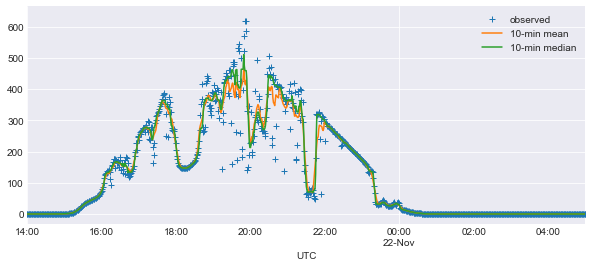

In [62]:
fig,ax = plt.subplots(figsize=(10,4))
ps7['E'].plot(ax=ax,ls='none',marker='+',label='observed')
srad_10min_mean.plot(ax=ax,label='10-min mean')
srad_10min_median.plot(ax=ax,label='10-min median')
#ax.set_xlim((pd.to_datetime('2016-11-21 17:00'),pd.to_datetime('2016-11-22 05:00')))
ax.set_xlim((pd.to_datetime('2016-11-21 14:00'),pd.to_datetime('2016-11-22 05:00')))
ax.legend()

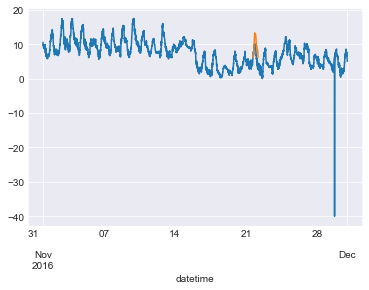

In [63]:
ps7['Temperature'].plot()
KDLS['air_temperature_C'].plot()

## Calculate (better?) estimate of shear, including 3-m data
This actually doesn't make sense because there's a change in elevation between the towers

## Read Siemens' lidar data (processed by Mithu)
converted with /Users/equon/WFIP2/Siemens/process_siemens_lidar_matlab.ipynb

In [64]:
lidar = pd.read_csv('Siemens/Siemens_Nov2016_10min.csv')
lidar['datetime'] = pd.to_datetime(lidar['datetime'])
lidar = lidar.set_index('datetime')

In [65]:
speed_table = lidar.pivot(columns='height',values='speed')

In [66]:
lidar_shear_10min = pd.Series(name='shear', index=speed_table.index)

for tstamp,rowdata in speed_table.iterrows():
    rowdata = rowdata[rowdata.notna()]
    if len(rowdata) < 2:
        print('Skipping',tstamp)
        alpha = np.nan
    elif zref not in rowdata.index:
        print('Skipping',tstamp,'(no U at zref)')
        alpha = np.nan
    else:
        zfit = np.array(rowdata.index)
        Ufit = rowdata.values
        alpha, R2 = fit_power_law_alpha(zfit, Ufit, zref=zref, Uref=rowdata[zref])
        if R2 < R2_min:
            alpha = np.nan
        #print(tstamp,len(Ufit),alpha,R2)
    lidar_shear_10min[tstamp] = alpha
    #print(tstamp,len(rowdata),rowdata)

('Skipping', Timestamp('2016-11-15 12:59:59'), '(no U at zref)')
('Skipping', Timestamp('2016-11-15 15:19:59'))
('Skipping', Timestamp('2016-11-16 05:20:00'), '(no U at zref)')


## Read eddypro surface met at PS11, PS06, PS02, PS01

In [67]:
def read_eddypro_full_output(*args):
    dflist = []
    for fname in args:
        with open(fname,'r') as f:
            f.readline()
            header = f.readline().strip().split(',')
            f.readline() # units
            dflist.append( pd.read_csv(f,names=header,parse_dates={'datetime':['date','time']}) )
    return pd.concat(dflist).set_index('datetime')

In [68]:
PS11 = read_eddypro_full_output('PS11/met.z23.b0.20161121.000000.son10m.full_output.csv',
                                'PS11/met.z23.b0.20161122.000000.son10m.full_output.csv')

IOError: [Errno 2] No such file or directory: 'PS11/met.z23.b0.20161121.000000.son10m.full_output.csv'

In [ ]:
PS06 = read_eddypro_full_output('PS06/met.z21.b0.20161121.000000.son21m.full_output.csv',
                                'PS06/met.z21.b0.20161122.000000.son21m.full_output.csv')

In [ ]:
PS02 = read_eddypro_full_output('PS02/met.z19.b0.20161121.000000.son17m.full_output.csv',
                                'PS02/met.z19.b0.20161122.000000.son17m.full_output.csv')

In [ ]:
PS01 = read_eddypro_full_output('PS01/met.z18.b0/met.z18.b0.20161121.000000.son10m.full_output.csv',
                                'PS01/met.z18.b0/met.z18.b0.20161122.000000.son10m.full_output.csv')

## Read SODAR data from PS01

In [ ]:
sodar = wfip2.read_dir(dpath=ps01_dpath,
                       reader=pd.read_csv,
                       prefix=ps01_prefix,
                       ext=ps01_ext,
                       parse_dates=['date_time'])

In [ ]:
sodar = sodar.set_index('date_time')

In [ ]:
sodar.head()

In [ ]:
sodar_speed_table = sodar.pivot(columns='height',values='speed')

In [ ]:
sodar_shear_10min = pd.Series(name='shear', index=sodar_speed_table.index)

for tstamp,rowdata in sodar_speed_table.iterrows():
    rowdata = rowdata[rowdata.notna()]
    if len(rowdata) < 2:
        print('Skipping',tstamp)
        alpha = np.nan
    elif zref not in rowdata.index:
        print('Skipping',tstamp,'(no U at zref)')
        alpha = np.nan
    else:
        zfit = np.array(rowdata.index)
        Ufit = rowdata.values
        alpha, R2 = fit_power_law_alpha(zfit, Ufit, zref=zref, Uref=rowdata[zref])
        if R2 < R2_min:
            alpha = np.nan
        #print(tstamp,len(Ufit),alpha,R2)
    sodar_shear_10min[tstamp] = alpha
    #print(tstamp,len(rowdata),rowdata)

In [ ]:
fig,ax = wfip2.plot_wind(sodar,datetime_range=('2016-11-21','2016-11-23'))
ax[0].set_ylabel('height [m]')
ax[1].set_ylabel('height [m]')
plt.tight_layout()
fig.savefig('sodar_20161121.png',dpi=150)

## Read radar
processed with Wasco/Wasco_radar.ipynb

## PLOTS

In [ ]:
fig,ax = plt.subplots(nrows=4,sharex=True,figsize=(10,8))

sonic80s_1min['wind_speed'].plot(ax=ax[0],label='south boom')
sonic80w_1min['wind_speed'].plot(ax=ax[0],label='west boom')
sonic80s_1min['wind_direction'].plot(ax=ax[1],label='south boom')
sonic80w_1min['wind_direction'].plot(ax=ax[1],label='west boom')
sonic80s_1min['TI_pct'].plot(ax=ax[2],label='south boom')
sonic80w_1min['TI_pct'].plot(ax=ax[2],label='west boom')

scada_1min['power_kw'].plot(ax=ax[3],ls='--',color='k',label='plant mean')
#frontdata['power_kw'].plot(ax=ax[3],label='front row mean (assumed 270 deg)')
front_row_mean.plot(ax=ax[3],color='k',label='front row mean')

ax[-1].set_xlim((plotstart,plotend))
plottimes = pd.date_range(plotstart,plotend,freq='1H')
plotlocal = plottimes.tz_localize(pytz.utc).tz_convert(timezone_str)
ax[-1].set_xticks(plottimes)

xlabels = [t.strftime('%H:%M\n')+tloc.strftime('%H:%M') for t,tloc in zip(plottimes,plotlocal)]

ax[-1].set_xticklabels(xlabels)
ax[-1].set_xlabel('UTC / local time')
#ax[-1].xaxis.set_major_locator(mdates.HourLocator())
#ax[-1].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M\n%b %d %Y'))

ax[1].set_ylim((202.5,292.5))
#ax[1].yaxis.set_ticks((180,225,270,315))
ax[1].yaxis.set_ticks(np.arange(202.5,315.0,22.5))
ax[2].set_ylim((0,21)) # TI 

ax[0].legend(loc='best')
ax[1].legend(loc='best')
ax[2].legend(loc='best')
ax[3].legend(loc='best')
ax[0].set_ylabel('wind speed [m/s]')
ax[1].set_ylabel('wind direction [deg]')
ax[2].set_ylabel('turbulence intensity [%]')
ax[3].set_ylabel('power output [kW]')
plt.minorticks_off()

#fig.suptitle('2016-11-21')
fig.savefig('wind_20161121_80m.png',dpi=150)

In [ ]:
selected_turbines = [25,26,27] # downwind of PS12
plotstart = pd.to_datetime('2016-11-21 17:00')
plotend = pd.to_datetime('2016-11-22 05:00')

fig,ax = plt.subplots(figsize=(10,5))
nearPS12_mean_output = None
for tid in selected_turbines:
    turbname = 'tower{:03d}'.format(tid)
    df = plant.scada.df.set_index(tindex)
    timerange = (df.index >= plotstart) & (df.index <= plotend)
    select = (df['id'] == turbname) & timerange
    ratedMW = plant.asset.df.query("id == '"+turbname+"'")['rated_power_kw'] / 1000.
    Poutput = df.loc[select,'power_kw']
    Poutput.plot(lw=1,alpha=0.75,label='turbine {:d} ({:.1f} MW)'.format(tid,float(ratedMW)))
    try: 
        nearPS12_mean_output += Poutput
    except TypeError: 
        nearPS12_mean_output = Poutput

nearPS12_mean_output /= len(selected_turbines)
nearPS12_mean_output.plot(color='k',ls='none',marker='o',markersize=5,fillstyle='none',label='near PS12')

timerange = (front_row_mean.index >= plotstart) & (front_row_mean.index <= plotend)
front_row_mean.loc[timerange].plot(ls='-',lw=2,color='k',label='front row mean')

timerange = (scada_1min.index >= plotstart) & (scada_1min.index <= plotend)
scada_1min['power_kw'].loc[timerange].plot(ls='--',lw=2,color='k',label='plant mean')

#ax.xaxis.set_major_locator(mdates.HourLocator())
#ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

#ax.set_xlabel('local time ['+timezone_str+']')
#ax.set_title('2016-11-21')
#ax.set_xlabel('local time (2016-11-21)')
ax.set_ylabel('power [kw]')
legend = ax.legend(loc='upper left',bbox_to_anchor=(1.05,1))

fig.savefig('power_nearPS12.png',dpi=150,bbox_extra_artists=(legend,),bbox_inches='tight')

In [ ]:
selected_turbines = [323,324,325] # turbines, NW of PS12

fig,ax = plt.subplots(figsize=(10,5))
control_mean_output = None
for tid in selected_turbines:
    turbname = 'tower{:03d}'.format(tid)
    df = plant.scada.df.set_index(tindex)
    timerange = (df.index >= plotstart) & (df.index <= plotend)
    select = (df['id'] == turbname) & timerange
    ratedMW = plant.asset.df.query("id == '"+turbname+"'")['rated_power_kw'] / 1000.
    Poutput = df.loc[select,'power_kw']
    Poutput.plot(lw=1,alpha=0.75,label='turbine {:d} ({:.1f} MW)'.format(tid,float(ratedMW)))
    try: 
        control_mean_output += Poutput
    except TypeError: 
        control_mean_output = Poutput

control_mean_output /= len(selected_turbines)
control_mean_output.plot(color='k',ls='none',marker='o',markersize=5,fillstyle='none',label='near PS12 (NW)')

timerange = (front_row_mean.index >= plotstart) & (front_row_mean.index <= plotend)
front_row_mean.loc[timerange].plot(ls='-',lw=2,color='k',label='front row mean')

timerange = (scada_1min.index >= plotstart) & (scada_1min.index <= plotend)
scada_1min['power_kw'].loc[timerange].plot(ls='--',lw=2,color='k',label='plant mean')

#ax.xaxis.set_major_locator(mdates.HourLocator())
#ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

#ax.set_xlabel('local time ['+timezone_str+']')
#ax.set_title('2016-11-21')
#ax.set_xlabel('local time (2016-11-21)')
ax.set_ylabel('power [kw]')
legend = ax.legend(loc='upper left',bbox_to_anchor=(1.05,1))

fig.savefig('power_control.png',dpi=150,bbox_extra_artists=(legend,),bbox_inches='tight')

In [ ]:
selected_turbines = range(301,310) # NW cluster: tower301-309
plotstart = pd.to_datetime('2016-11-21 17:00')
plotend = pd.to_datetime('2016-11-22 05:00')

fig,ax = plt.subplots(figsize=(10,5))
mean_output = None
mean_wspd = None
mean_wdir = None
mean1_output = None # front of NW cluster
mean1_wspd = None
mean1_wdir = None
for tid in selected_turbines:
    turbname = 'tower' + str(tid)
    df = plant.scada.df.set_index(tindex)
    timerange = (df.index >= plotstart) & (df.index <= plotend)
    select = (df['id'] == turbname) & timerange
    ratedMW = plant.asset.df.query("id == '"+turbname+"'")['rated_power_kw'] / 1000.
    Poutput = df.loc[select,'power_kw']
    Poutput.plot(lw=1,alpha=0.5,label='turbine {:d} ({:.1f} MW)'.format(tid,float(ratedMW)))
    try: 
        mean_output += Poutput
        mean_wspd += df.loc[select,'windspeed_ms']
        mean_wdir += df.loc[select,'winddirection_deg']
        if tid <= 305:
            mean1_output += Poutput
            mean1_wspd += df.loc[select,'windspeed_ms']
            mean1_wdir += df.loc[select,'winddirection_deg']
    except TypeError: 
        mean_output = Poutput.copy()
        mean_wspd = df.loc[select,'windspeed_ms']
        mean_wdir = df.loc[select,'winddirection_deg']
        mean1_output = Poutput.copy()
        mean1_wspd = df.loc[select,'windspeed_ms']
        mean1_wdir = df.loc[select,'winddirection_deg']
# rear row of NW cluster:
mean2_output = mean_output - mean1_output
mean2_wspd = mean_wspd - mean1_wspd
mean2_wdir = mean_wdir - mean1_wdir

# means
mean_output /= len(selected_turbines)
mean_wspd /= len(selected_turbines)
mean_wdir /= len(selected_turbines)
mean1_output /= 5
mean1_wspd /= 5
mean1_wdir /= 5
mean2_output /= 4
mean2_wspd /= 4
mean2_wdir /= 4

mean_output.plot(color='k',ls='none',marker='o',markersize=5,fillstyle='none',label='NW cluster mean')

timerange = (front_row_mean.index >= plotstart) & (front_row_mean.index <= plotend)
front_row_mean.loc[timerange].plot(ls='-',lw=2,color='k',label='front row mean')

timerange = (scada_1min.index >= plotstart) & (scada_1min.index <= plotend)
scada_1min['power_kw'].loc[timerange].plot(ls='--',lw=2,color='k',label='plant mean')

#ax.xaxis.set_major_locator(mdates.HourLocator())
#ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

#ax.set_xlabel('local time ['+timezone_str+']')
#ax.set_title('2016-11-21')
#ax.set_xlabel('local time (2016-11-21)')
ax.set_ylabel('power [kw]')
legend = ax.legend(loc='upper left',bbox_to_anchor=(1.05,1))

fig.savefig('power_NWcluster.png',dpi=150,bbox_extra_artists=(legend,),bbox_inches='tight')

In [ ]:
fig,ax = plt.subplots(nrows=4,sharex=True,figsize=(10,8))

# WIND SPEED
PS12_80m_1min['wind_speed'].plot(ax=ax[0],label='met, 80 m')
PS12_50m_1min['wind_speed'].plot(ax=ax[0],label='met, 50 m')
# vmet2['windspeed_50m_ms'].plot(ax=ax[0],label='met2, 50 m')
# vmet2['windspeed_80m_ms'].plot(ax=ax[0],label='met2, 80 m')
KDLS['wind_speed_ms'].plot(ax=ax[0],ls='none',marker='^',color='k',label='ground')
mean_wspd.plot(ax=ax[0],color='k',ls='none',marker='o',markersize=5,fillstyle='none',label='NW cluster mean')

ax[0].set_ylabel(r'wind speed [m/s]')
ax[0].set_ylim((0,14))
ax[0].yaxis.set_ticks(np.arange(0,14.1,2))

# WIND DIRECTION
PS12_80m_1min['wind_direction'].plot(ax=ax[1],label='met, 80 m')
PS12_50m_1min['wind_direction'].plot(ax=ax[1],label='met, 50 m')
# vmet2['winddirection_50m_deg'].plot(ax=ax[1],label='met2, 50 m')
# vmet2['winddirection_80m_deg'].plot(ax=ax[1],label='met2, 50 m')
KDLS['wind_direction_deg'].plot(ax=ax[1],ls='none',marker='^',color='k',label='ground')
mean_wdir.plot(ax=ax[1],color='k',ls='none',marker='o',markersize=5,fillstyle='none',label='NW cluster mean')

ax[1].set_ylabel(r'wind direction [$^\circ$]')
ax[1].yaxis.set_ticks(np.arange(180,360.1,22.5))
ax[1].set_ylim((180,360))

# TEMPERATURE
PS12_50m_1min['temperature'].plot(ax=ax[2],label='met, 50 m')
PS12_80m_1min['temperature'].plot(ax=ax[2],label='met, 80 m')
KDLS['air_temperature_C'].plot(ax=ax[2],ls='none',marker='^',color='k')

ax[2].set_ylabel(r'temperature [K]')

# POWER OUTPUT
scada_1min['power_kw'].plot(ax=ax[3],ls='--',color='k',label='plant mean')
front_row_mean.plot(ax=ax[3],color='k',label='front row mean')
#mean_output.plot(ax=ax[3],color='k',ls='none',marker='o',markersize=5,fillstyle='none',label='NW cluster mean')
mean1_output.plot(ax=ax[3],color='k',ls='none',marker='o',markersize=5,fillstyle='none',label='NW cluster mean (row1)')
mean2_output.plot(ax=ax[3],color='r',ls='none',marker='o',markersize=5,fillstyle='none',alpha=0.5,label='NW cluster mean (row2)')

ax[3].set_ylabel(r'power output [kW]')

# misc plot formatting
ax[0].legend(loc='best')
# ax[1].legend(loc='best')
# ax[2].legend(loc='best')
ax[3].legend(loc='best')

clean_up_xaxis(ax)

highlight_period(ax)

# save figure
plt.tight_layout()
fig.savefig('measurements_20161121.png',dpi=150)

In [ ]:
#
# CLEANED UP FOR MATT (BLT June 14, 2018)
#

fig,ax = plt.subplots(nrows=4,sharex=True,figsize=(10,10))

# WIND SPEED
PS12_80m_1min['wind_speed'].plot(ax=ax[0],label='met, 80 m')
PS12_50m_1min['wind_speed'].plot(ax=ax[0],label='met, 50 m')
KDLS['wind_speed_ms'].plot(ax=ax[0],ls='none',marker='^',color='k',label='Dalles airport')
mean_wspd.plot(ax=ax[0],color='k',ls='none',marker='o',markersize=5,fillstyle='none',label='NW cluster mean')

ax[0].set_ylabel(r'wind speed [m/s]')
ax[0].set_ylim((0,13))
ax[0].yaxis.set_ticks(np.arange(0,13.1,2))

# WIND DIRECTION
PS12_80m_1min['wind_direction'].plot(ax=ax[1],label='met, 80 m')
PS12_50m_1min['wind_direction'].plot(ax=ax[1],label='met, 50 m')
KDLS['wind_direction_deg'].plot(ax=ax[1],ls='none',marker='^',color='k',label='ground')
mean_wdir.plot(ax=ax[1],color='k',ls='none',marker='o',markersize=5,fillstyle='none',label='NW cluster mean')

ax[1].set_ylabel(r'wind direction [$^\circ$]')
ax[1].yaxis.set_ticks(np.arange(180,360.1,22.5))
ax[1].set_ylim((180,360))

# TEMPERATURE
PS12_50m_1min['temperature'].plot(ax=ax[2],label='met, 50 m')
PS12_80m_1min['temperature'].plot(ax=ax[2],label='met, 80 m')
KDLS['air_temperature_C'].plot(ax=ax[2],ls='none',marker='^',color='k')

ax[2].set_ylabel(r'temperature [$^\circ$C]')
ax[2].set_ylim((5,14))

# POWER OUTPUT
#scada_1min['power_kw'].plot(ax=ax[3],ls='--',color='k',label='plant mean')
front_row_mean_norm = front_row_mean / 2300
mean1_output_norm = mean1_output / 2300
mean2_output_norm = mean2_output / 2300
front_row_mean_norm.plot(ax=ax[3],color='k',label='front row mean')
mean1_output_norm.plot(ax=ax[3],color='k',ls='none',marker='o',markersize=5,fillstyle='none',label='NW cluster mean (row1)')
mean2_output_norm.plot(ax=ax[3],color='r',ls='none',marker='o',markersize=5,fillstyle='none',alpha=0.5,label='NW cluster mean (row2)')

ax[3].set_ylabel(r'normalized power output')

# misc plot formatting
ax[0].legend(loc='best',ncol=2)
# ax[1].legend(loc='best')
# ax[2].legend(loc='best')
ax[3].legend(loc='best')

clean_up_xaxis(ax)

#highlight_period(ax)

# save figure
plt.tight_layout()
fig.savefig('measurements_CLEAN_20161121.png',dpi=150)

In [ ]:
#
# CLEANED UP FOR SCITECH ABSTRACT (June 18, 2018)
#

fig,ax = plt.subplots(nrows=4,sharex=True,figsize=(10,10))

# WIND SPEED
PS12_80m_1min['wind_speed'].plot(ax=ax[0],label='met12, 80 m')
PS12_50m_1min['wind_speed'].plot(ax=ax[0],label='met12, 50 m')
ps7['U'].plot(ax=ax[0],label='met7, 3 m')
#KDLS['wind_speed_ms'].plot(ax=ax[0],ls='none',marker='^',color='k',label='Dalles airport')
mean_wspd.plot(ax=ax[0],color='k',ls='none',marker='o',markersize=5,fillstyle='none',label='NW cluster mean')

ax[0].set_ylabel(r'wind speed [m/s]')
ax[0].set_ylim((0,13))
ax[0].yaxis.set_ticks(np.arange(0,13.1,2))

# WIND DIRECTION
PS12_80m_1min['wind_direction'].plot(ax=ax[1],label='met12, 80 m')
PS12_50m_1min['wind_direction'].plot(ax=ax[1],label='met12, 50 m')
ps7['ThetaU'].plot(ax=ax[1],label='met7, 3 m')
#KDLS['wind_direction_deg'].plot(ax=ax[1],ls='none',marker='^',color='k',label='ground')
mean_wdir.plot(ax=ax[1],color='k',ls='none',marker='o',markersize=5,fillstyle='none',label='NW cluster mean')

ax[1].set_ylabel(r'wind direction [$^\circ$]')
# ax[1].yaxis.set_ticks(np.arange(180,360.1,22.5))
# ax[1].set_ylim((180,360))
ax[1].yaxis.set_ticks(np.arange(180,315.1,22.5))
ax[1].set_ylim((180,315))

# TEMPERATURE
PS12_50m_1min['temperature'].plot(ax=ax[2],label='met12, 50 m')
PS12_80m_1min['temperature'].plot(ax=ax[2],label='met12, 80 m')
ps7['Temperature'].plot(ax=ax[2],label='met7, 3 m')
#KDLS['air_temperature_C'].plot(ax=ax[2],ls='none',marker='^',color='k')

ax[2].set_ylabel(r'temperature [$^\circ$C]')
#|ax[2].set_ylim((5,14))
ax[2].yaxis.set_ticks(np.arange(2,11))
ax[2].set_ylim((3,10.5))

# downwelling shortwave solar radiation 
# ax2 = ax[2].twinx()
# ps7['E'].plot(ax=ax2,ls='none',marker='.',color='g',label='solar radiation')
# ax2.grid(False)
# ax2.set_ylabel(r'solar radiation [W/m$^2$]')
# ax2.legend()

# POWER OUTPUT
#scada_1min['power_kw'].plot(ax=ax[3],ls='--',color='k',label='plant mean')
front_row_mean_norm = front_row_mean / 2300
mean1_output_norm = mean1_output / 2300
mean2_output_norm = mean2_output / 2300
front_row_mean_norm.plot(ax=ax[3],color='k',label='front row mean')
mean1_output_norm.plot(ax=ax[3],color='k',ls='none',marker='o',markersize=5,fillstyle='none',label='NW cluster mean (row1)')
mean2_output_norm.plot(ax=ax[3],color='r',ls='none',marker='o',markersize=5,fillstyle='none',alpha=0.5,label='NW cluster mean (row2)')

ax[3].set_ylabel(r'normalized power output')

# misc plot formatting
ax[0].legend(loc='best')
# ax[1].legend(loc='best')
# ax[2].legend(loc='best')
ax[3].legend(loc='best')

clean_up_xaxis(ax)
#ax[0].set_xlim((pd.to_datetime('2016-11-21 14:00:00'),plotend))

#highlight_period(ax)
highlight_period(ax,pd.to_datetime('2016-11-21 22:00'),pd.to_datetime('2016-11-21 23:00'))

# save figure
plt.tight_layout()
fig.savefig('measurements_scitech_20161121.png',dpi=150)

In [ ]:
fig,ax = plt.subplots(nrows=4,sharex=True,figsize=(10,8))

# SHEAR
#PS12_shear_1min.plot(ax=ax[0],label='met12')
PS12_shear_1min.resample('10min').mean().plot(ax=ax[0],label='met12')
sodar_selected = sodar_shear_10min.loc[(sodar_shear_10min.index >= plotstart) & (sodar_shear_10min.index <= plotend)]
sodar_selected.plot(ax=ax[0],color=colors[3],marker='o',markersize=4,ls='none',label='sodar')
lidar_selected = lidar_shear_10min.loc[(lidar_shear_10min.index >= plotstart) & (lidar_shear_10min.index <= plotend)]
lidar_selected.plot(ax=ax[0],color=colors[4],marker='o',markersize=4,ls='none',label='lidar')
#radar_selected = radar_shear_1hr.loc[(radar_shear_1hr.index >= plotstart) & (radar_shear_1hr.index <= plotend)]
#radar_selected.plot(ax=ax[0],color=colors[5],marker='s',markersize=4,ls='none',label='radar')

ax[0].set_ylabel(r'shear exponent [-]')
ax[0].set_ylim((0,0.7)) # shear
ax[0].yaxis.set_ticks(np.arange(0,0.71,0.1))

# TI
PS12_80m_1min['TI_pct'].resample('10min').mean().plot(ax=ax[1],label='met12, 80 m')
#PS12_50m_1min['TI_pct'].plot(ax=ax[1],label='met12, 50 m')
PS12_80m_1min['TIxy_pct'].resample('10min').mean().plot(ax=ax[1],ls='--',color=ax[0].get_lines()[0].get_color(),label='')
#PS12_50m_1min['TIxy_pct'].plot(ax=ax[1],ls='--',color=ax[0].get_lines()[1].get_color(),label='')
TI_sodar = sodar['turbulence'] * 100
TI_sodar.loc[sodar['height']==80].plot(ax=ax[1],color=colors[3],marker='o',markersize=4,ls='none',label='sodar')
lidar.loc[lidar['height']==80,'TI'].plot(ax=ax[1],color=colors[4],marker='o',markersize=4,ls='none',label='lidar')

ax[1].set_ylim((0,30)) # TI
ax[1].yaxis.set_ticks(np.arange(0,31,5))
ax[1].set_ylabel(r'turbulence intensity [%]')

# TKE
PS12_80m_1min['TKE'].resample('10min').mean().plot(ax=ax[2],label='met12 (80 m)')
#PS12_50m_1min['TKE'].resample('10min').mean().plot(ax=ax[2],label='met12 (50 m)')
#PS11['TKE'].plot(ax=ax[2],color=colors[8],label='met11 (10 m')
PS06['TKE'].plot(ax=ax[2],color=colors[5],label='met6 (21 m)')
PS02['TKE'].plot(ax=ax[2],color=colors[8],label='met2 (17 m)')
PS01['TKE'].plot(ax=ax[2],color=colors[7],label='met1 (10 m)')

ax[2].set_ylabel(r'turbulent kinetic energy [m$^2$/s$^2$]')
ax[2].set_ylim((0,1.5))

# RICHARDSON NO.
#PS12_richno_10min.plot(ax=ax[3],label='met 12')
#ax3 = ax[3].twinx()
#PS11['(z-d)/L'].plot(ax=ax[3],color=colors[8],label='met11 (10 m)')
PS06['(z-d)/L'].plot(ax=ax[3],color=colors[5],label='met6 (21 m)')
PS02['(z-d)/L'].plot(ax=ax[3],color=colors[8],label='met2 (17 m)')
PS01['(z-d)/L'].plot(ax=ax[3],color=colors[7],label='met1 (10 m)')

#ax[3].set_ylabel(r'Bulk Richardson number [-]')
#ax[3].set_ylim((-20,20))
ax[3].set_ylabel(r'Obukhov stability parameter [-]')
ax[3].set_ylim((-2,2))

# misc plot formatting
ax[0].legend(loc='best')
#ax[1].legend(loc='best')
ax[2].legend(loc='best',ncol=2)
#ax[3].legend(loc='best')

clean_up_xaxis(ax)

#highlight_period(ax)
highlight_period(ax,pd.to_datetime('2016-11-21 22:00'),pd.to_datetime('2016-11-21 23:00'))

# save figure
plt.tight_layout()
fig.savefig('calculations_scitech_20161121.png',dpi=150)

## other calculations

## Process RASS data

In [ ]:
# by default, ESLR_wind_profiler expects a "WINDS" input
# need to set RASS-specific number of returns and the correct columns to QC
rass = wfip2.read_dir(dpath=rass_dpath,
                      reader=remote_sensing.ESRL_wind_profiler,
                      prefix=rass_prefix,
                      ext=rass_ext,
                      modes=1,check_bad=['T','Tc','W'])

In [ ]:
rass = rass.set_index('date_time')

In [ ]:
rass = rass.loc[(rass.index >= plotstart) & (rass.index <= plotend)]

In [ ]:
rass.head()

In [ ]:
T = rass.pivot(columns='HT',values='T')   # uncorrected temperatures [deg C]
Tc = rass.pivot(columns='HT',values='Tc') # corrected consensus temperatures [deg C]
W = rass.pivot(columns='HT',values='W')   # vertical velocity [m/s]
T += 273.15
Tc += 273.15

Get surface pressure from microbarograph

Calculate potential temperature assuming an idealized isothermal atmosphere

In [ ]:
rass['pressure_mb'] = np.nan
rass['id'] = 'rass'
temp1 = rass[['pressure_mb','id']]

In [ ]:
ps7['id'] = 'ps7'
temp2 = ps7[['id']].copy()
temp2['pressure_mb'] = ps7['P']

In [ ]:
temp = pd.concat([temp1,temp2]).sort_index()

In [ ]:
temp = temp.interpolate(method='values')

In [ ]:
rass['pressure0_mb'] = temp.loc[temp['id']=='rass','pressure_mb'] # surface pressure -- NOT USED?

In [ ]:
# hypsometric eqn: Z2 - Z1 = Hmean * np.log(p1/p2), Hmean ~= 8 km
Hmean = 8 # km
Z0 = 0.002 # km, mbr at 2 m
p0_p = np.exp((rass['HT'] - Z0)/Hmean)

In [ ]:
# Poisson eqn: theta = T * (p0/p)**0.286
rass['theta'] = (rass['Tc']+273.15) * p0_p**0.286

In [ ]:
# Approximation to theta (Stull, Eqn. 1.5.1d)
rass['theta_approx'] = (rass['Tc']+273.15) + 0.0098*rass['HT']*1000

In [ ]:
theta = rass.pivot(columns='HT',values='theta')   # estimated potential temperature [K]

In [ ]:
theta_approx = rass.pivot(columns='HT',values='theta_approx')   # estimated potential temperature [K]

plot it

In [ ]:
t = T.index
HT = T.columns # in km

In [ ]:
tt,zz = np.meshgrid(t,HT,indexing='ij')

In [ ]:
9.81/(1.4*287.05/.4)

In [ ]:
Tlevels = np.arange(273,283.5,0.5)
Wlevels = np.arange(-0.75,0.76,0.05)

fig,ax = plt.subplots(nrows=4, figsize=(11,11), sharey=True)
cont0 = ax[0].contourf(tt,1000*zz,T,Tlevels,cmap='magma')
cont1 = ax[1].contourf(tt,1000*zz,Tc,Tlevels,cmap='magma')
#cont2 = ax[2].contourf(tt,1000*zz,W,Wlevels,cmap='coolwarm')
cont2 = ax[2].contourf(tt,1000*zz,theta,cmap='magma')
cont3 = ax[3].contourf(tt,1000*zz,theta_approx,cmap='magma')
plt.colorbar(cont0,ax=ax[0])
plt.colorbar(cont1,ax=ax[1])
plt.colorbar(cont2,ax=ax[2])
plt.colorbar(cont3,ax=ax[3])

ax[0].set_ylim((0,1000))

## Get target values in focus period

In [ ]:
focus_range = (PS12_80m_1min.index >= focusstart) & (PS12_80m_1min.index <= focusend)
focus_wspd = PS12_80m_1min.loc[focus_range,'wind_speed'].mean()
focus_wdir = PS12_80m_1min.loc[focus_range,'wind_direction'].mean()
focus_TI = PS12_80m_1min.loc[focus_range,'TI_pct'].mean()
focus_TI_min = PS12_80m_1min.loc[focus_range,'TI_pct'].min()
focus_TI_max = PS12_80m_1min.loc[focus_range,'TI_pct'].max()
focus_TIxy = PS12_80m_1min.loc[focus_range,'TIxy_pct'].mean()
focus_TIxy_min = PS12_80m_1min.loc[focus_range,'TIxy_pct'].min()
focus_TIxy_max = PS12_80m_1min.loc[focus_range,'TIxy_pct'].max()
focus_shear = PS12_shear_1min[focus_range].mean()
focus_shear_min = PS12_shear_1min[focus_range].min()
focus_shear_max = PS12_shear_1min[focus_range].max()

focus_range = (mean_wspd.index >= focusstart) & (mean_wspd.index <= focusend)
focus_wspd_turb = mean_wspd.loc[focus_range].mean()
focus_wdir_turb = mean_wdir.loc[focus_range].mean()

print('PS12 wind',focus_wspd, focus_wdir)
print('SCADA wind',focus_wspd_turb, focus_wdir_turb)
print('streamwise TI range',focus_TIxy_min, focus_TIxy, focus_TIxy_max)
print('cup-equivalent TI range',focus_TI_min, focus_TI, focus_TI_max)
print('shear range',focus_shear_min, focus_shear, focus_shear_max)

In [ ]:
KDLS['air_temperature_C']

In [ ]:
# estimated heating 
(13.3-8.3)/2

In [ ]:
plant.asset.parse_geometry()

In [ ]:
IDs = ['PS12']
turbinelist = [301,302,303,304,305,306,307,308,309,323,324,325]
IDs += [ 'tower'+str(i) for i in turbinelist ]
plant.asset.df['dummy'] = 0
utm_coords_list = plant.asset.df.pivot(index='dummy',columns='id',values='geometry')[IDs]

In [ ]:
x,y = [], []
for asset,coords in utm_coords_list.iteritems():
    x.append(coords[0].x)
    y.append(coords[0].y)
    print(asset,x[-1],y[-1])
x = np.array(x)
y = np.array(y)

In [ ]:
x -= x[0]
y -= y[0]

In [ ]:
for i,asset in enumerate(IDs):
    #print(asset,x[i],y[i])
    print('{:s} {:g} {:g}'.format(asset,x[i],y[i]))

In [ ]:
D = 93.
print(-3100 - 15*D, 3580 + 15*D)
print(2*D, -2*D)

In [ ]:
D/2.5, D/1.25